# Problem Statement

HELP International raised $10 million to aid underdeveloped countries. To allocate funds effectively, they will cluster countries based on socio-economic and health factors, prioritizing those most in need during disasters.

# Aim
To cluster countries based on numerical features.

# Dataset Attributes
- **country** : Name of the country
- **child_mort** : Death of children under 5 years of age per 1000 live births
- **exports** : Exports of goods and services per capita. Given as %age of the GDP per capita
- **health** : Total health spending per capita. Given as %age of GDP per capita
- **imports** : Imports of goods and services per capita. Given as %age of the GDP per capita
- **Income** : Net income per person
- **Inflation** : The measurement of the annual growth rate of the Total GDP
- **life_expec** : The average number of years a new born child would live if the current mortality patterns are to rem...
- **total_fer** : The number of children that would be born to each woman if the current age-fertility rates remain th...
- **gdpp** : The GDP per capita. Calculated as the Total GDP divided by the total population.

# Dataset

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
pd.options.display.float_format = '{:.2f}'.format
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler,StandardScaler
import warnings
warnings.filterwarnings('ignore')

from sklearn.cluster import KMeans, MiniBatchKMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.neighbors import NearestNeighbors

from scipy.cluster.hierarchy import dendrogram, linkage
from mpl_toolkits.mplot3d import Axes3D

import plotly.express as px
!pip install -U kaleido
import kaleido

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving Country-data.csv to Country-data.csv


In [ ]:
data = pd.read_csv('Country-data.csv')
data.head()

country  child_mort  exports  health  imports  income  \
0          Afghanistan       90.20    10.00    7.58    44.90    1610   
1              Albania       16.60    28.00    6.55    48.60    9930   
2              Algeria       27.30    38.40    4.17    31.40   12900   
3               Angola      119.00    62.30    2.85    42.90    5900   
4  Antigua and Barbuda       10.30    45.50    6.03    58.90   19100   

   inflation  life_expec  total_fer   gdpp  
0       9.44       56.20       5.82    553  
1       4.49       76.30       1.65   4090  
2      16.10       76.50       2.89   4460  
3      22.40       60.10       6.16   3530  
4       1.44       76.80       2.13  12200

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167 entries, 0 to 166
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   country     167 non-null    object 
 1   child_mort  167 non-null    float64
 2   exports     167 non-null    float64
 3   health      167 non-null    float64
 4   imports     167 non-null    float64
 5   income      167 non-null    int64  
 6   inflation   167 non-null    float64
 7   life_expec  167 non-null    float64
 8   total_fer   167 non-null    float64
 9   gdpp        167 non-null    int64  
dtypes: float64(7), int64(2), object(1)
memory usage: 13.2+ KB


Except **country**, all the features are numerical features.

In [ ]:
data.isnull().sum()

country       0
child_mort    0
exports       0
health        0
imports       0
income        0
inflation     0
life_expec    0
total_fer     0
gdpp          0
dtype: int64

There is **no null values** in the dataset.

In [ ]:
data.describe()

child_mort  exports  health  imports    income  inflation  life_expec  \
count      167.00   167.00  167.00   167.00    167.00     167.00      167.00   
mean        38.27    41.11    6.82    46.89  17144.69       7.78       70.56   
std         40.33    27.41    2.75    24.21  19278.07      10.57        8.89   
min          2.60     0.11    1.81     0.07    609.00      -4.21       32.10   
25%          8.25    23.80    4.92    30.20   3355.00       1.81       65.30   
50%         19.30    35.00    6.32    43.30   9960.00       5.39       73.10   
75%         62.10    51.35    8.60    58.75  22800.00      10.75       76.80   
max        208.00   200.00   17.90   174.00 125000.00     104.00       82.80   

       total_fer      gdpp  
count     167.00    167.00  
mean        2.95  12964.16  
std         1.51  18328.70  
min         1.15    231.00  
25%         1.79   1330.00  
50%         2.41   4660.00  
75%         3.88  14050.00  
max         7.49 105000.00

# EDA

## Distribution of each attribute

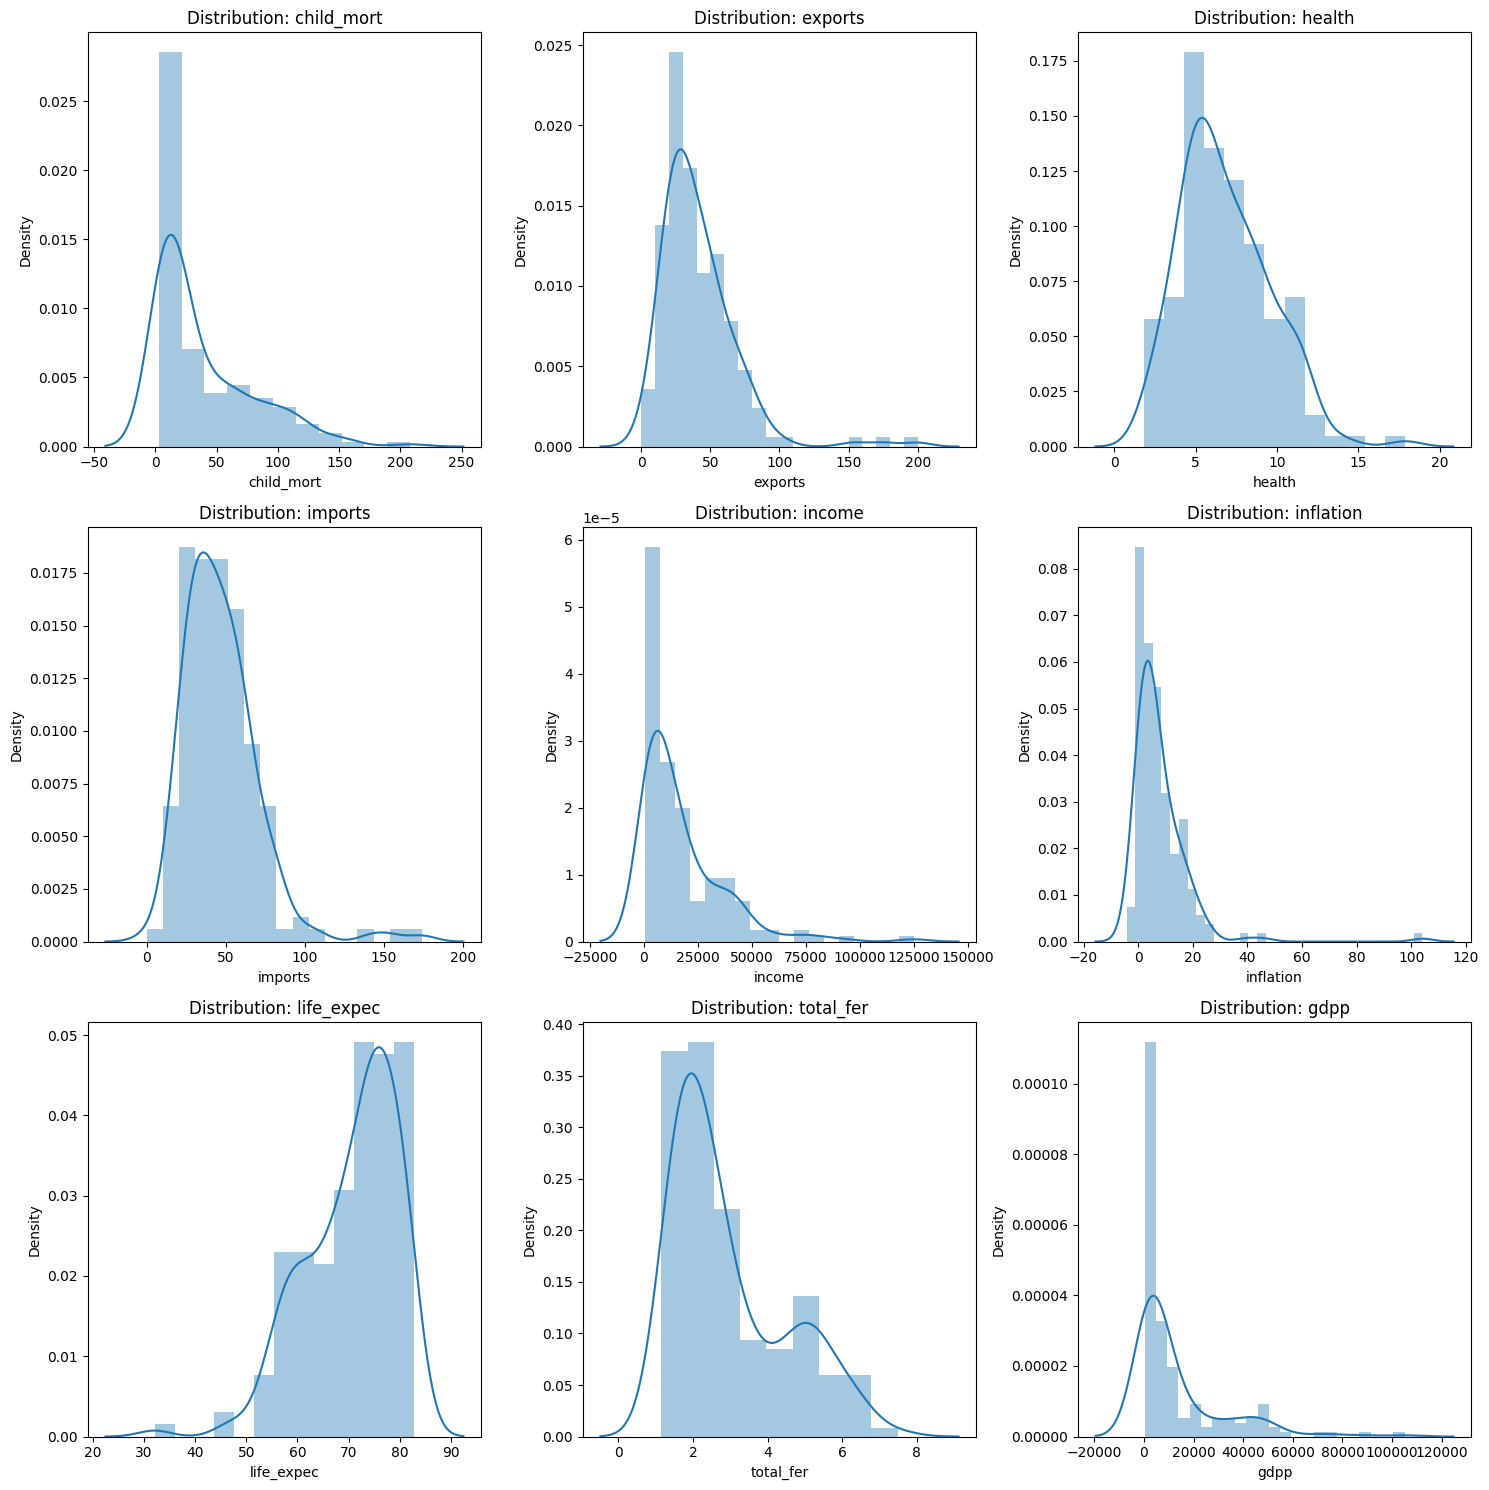

In [ ]:
categorical_features = ['country']
numerical_features = [col for col in data.columns if col != 'country']

fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(15, 15))
ax = ax.flatten()

for i in range(len(numerical_features)):
    sns.distplot(data[numerical_features[i]], ax=ax[i])
    ax[i].set_title(f'Distribution: {numerical_features[i]}')

plt.tight_layout()
plt.show()

- `life_expec` shows a left-skewed distribution.
- `health` shows a normal distribution.
- All other features demonstrate a right-skewed distribution.

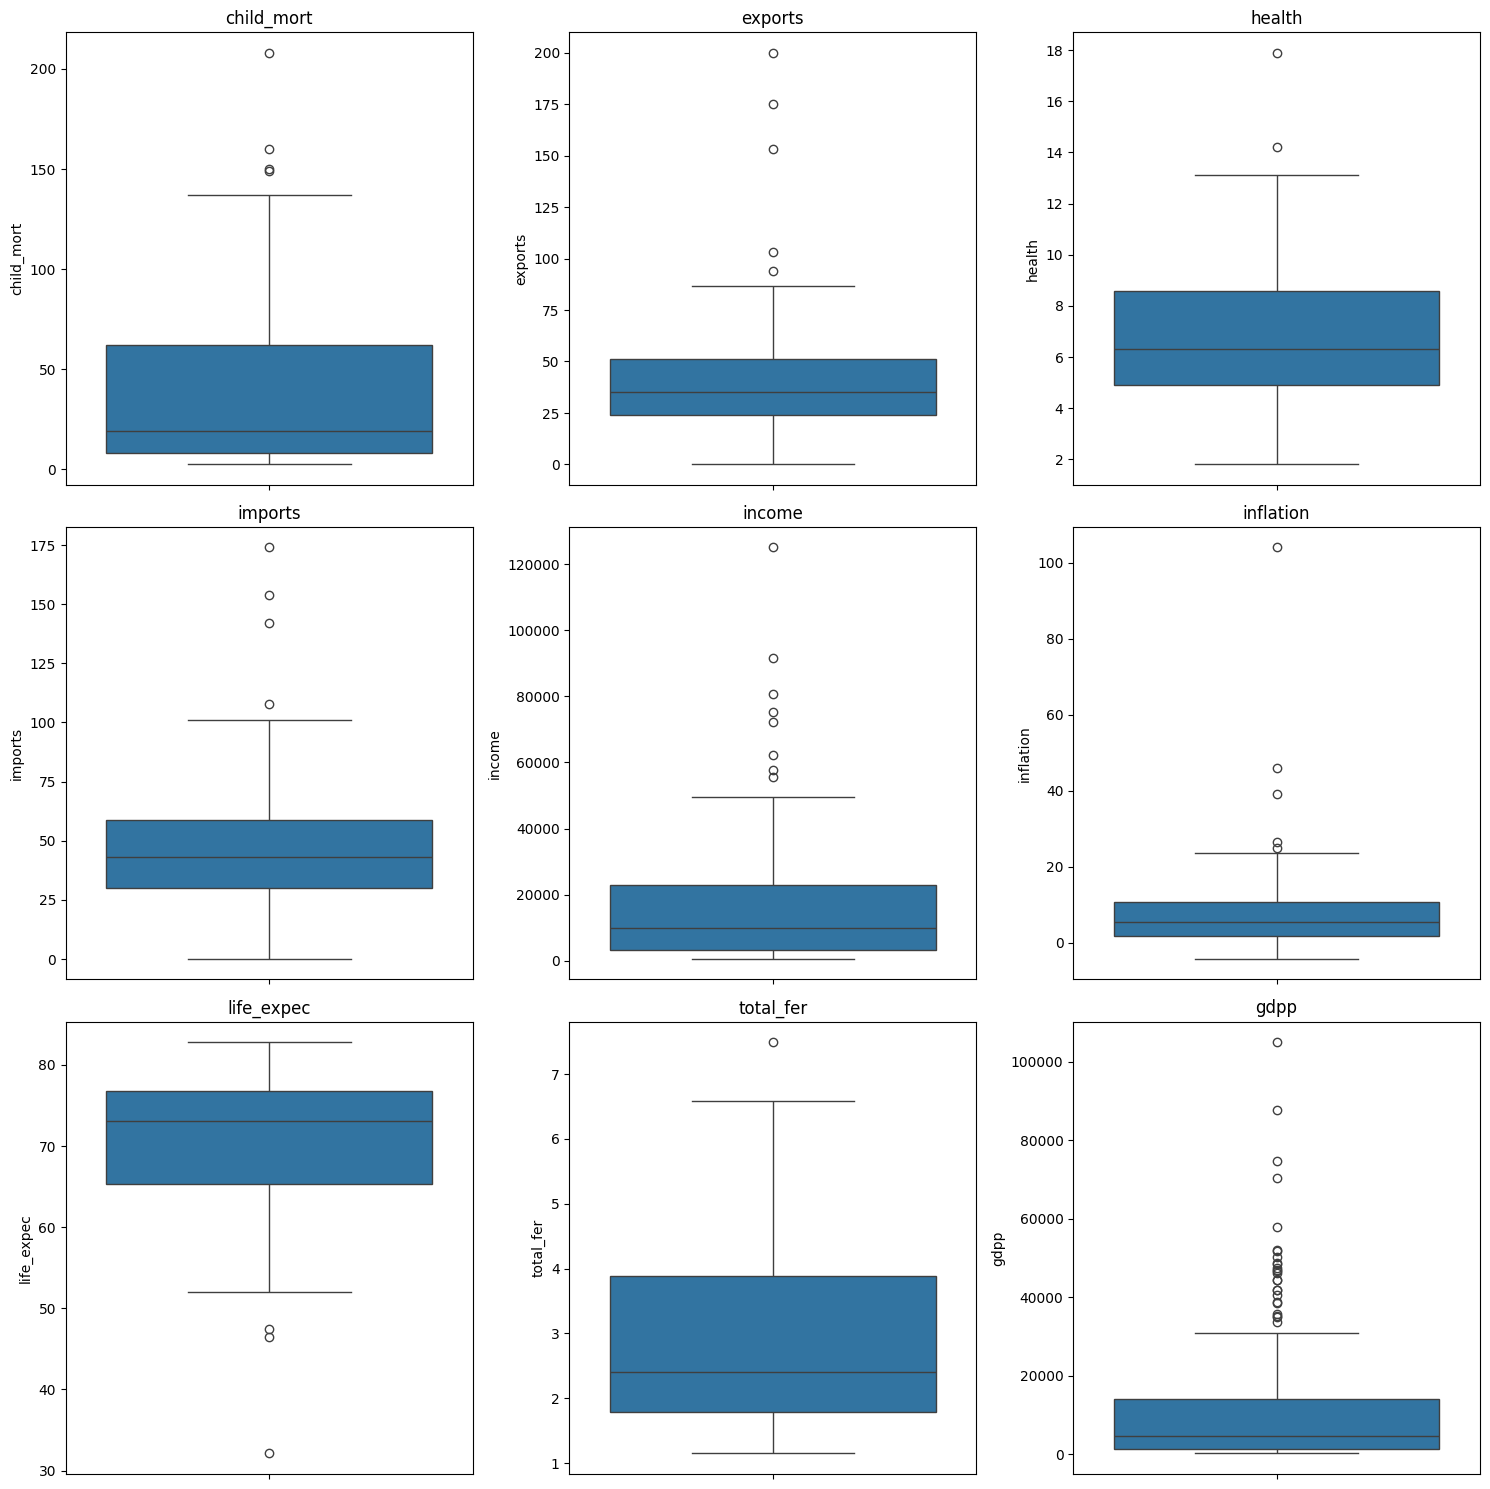

In [ ]:
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(15, 15))

ax = ax.flatten()

for i in range(len(numerical_features)):
    sns.boxplot(data=data[numerical_features[i]], ax=ax[i])
    ax[i].set_title(numerical_features[i])

plt.tight_layout()
plt.show()

# Feature Engineering

## Correlation Matrix

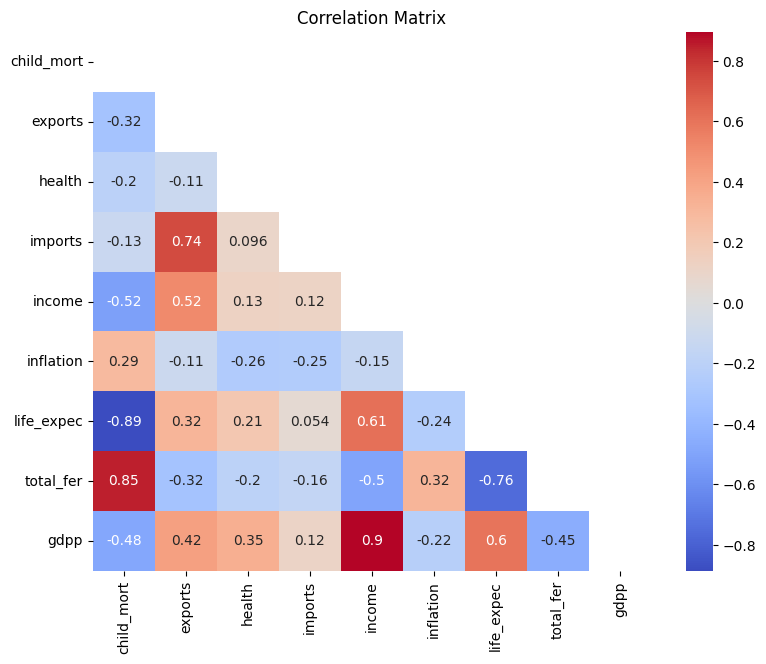

In [ ]:
numeric_data = data.drop(columns=['country'])

ut = np.triu(numeric_data.corr())

fig, ax = plt.subplots(figsize=(9, 7))
sns.heatmap(numeric_data.corr(), cmap='coolwarm', annot=True, cbar=True, mask=ut)
plt.title('Correlation Matrix')
plt.show()

## PCA

In [ ]:
mms = MinMaxScaler() # Normalization
ss = StandardScaler() # Standardization

df2 = data.copy(deep = True)
df2 = df2.drop('country', axis=1)

col = list(df2.columns)
col.remove('health')

df2['health'] = ss.fit_transform(df2[['health']]) # Standardization of 'health'

for i in col:
    df2[i] = mms.fit_transform(df2[[i]]) # Normalization (range between 0 and 1)

df2.head()

child_mort  exports  health  imports  income  inflation  life_expec  \
0        0.43     0.05    0.28     0.26    0.01       0.13        0.48   
1        0.07     0.14   -0.10     0.28    0.07       0.08        0.87   
2        0.12     0.19   -0.97     0.18    0.10       0.19        0.88   
3        0.57     0.31   -1.45     0.25    0.04       0.25        0.55   
4        0.04     0.23   -0.29     0.34    0.15       0.05        0.88   

   total_fer  gdpp  
0       0.74  0.00  
1       0.08  0.04  
2       0.27  0.04  
3       0.79  0.03  
4       0.15  0.11

Standardization and Normalization before PCA.

In [ ]:
pca = PCA()
pca_df2 = pd.DataFrame(pca.fit_transform(df2))
pca.explained_variance_

array([1.01740511, 0.13090418, 0.03450018, 0.02679822, 0.00979752,
       0.00803398, 0.00307055, 0.00239976, 0.00179388])

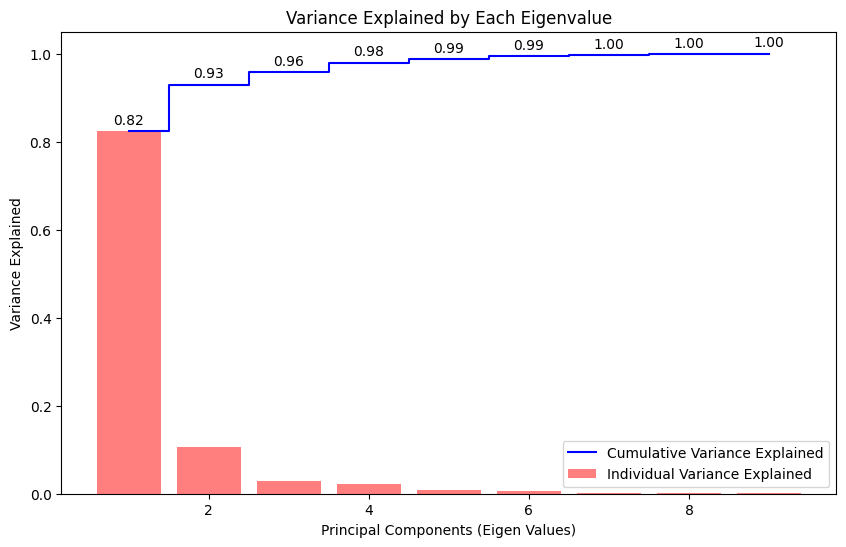

In [ ]:
cumulative_variance = np.cumsum(pca.explained_variance_ratio_) #
individual_variance = pca.explained_variance_ratio_ #

fig, ax = plt.subplots(figsize=(10, 6))

# Plot the cumulative explained variance as a step plot
ax.step(range(1, len(cumulative_variance) + 1), cumulative_variance, where='mid', label='Cumulative Variance Explained', color='b')

# Plot the individual explained variance as a histogram
ax.bar(range(1, len(individual_variance) + 1), individual_variance, align='center',alpha=0.5, label='Individual Variance Explained', color='r')

# Add labels to each point of the cumulative variance plot
for i, value in enumerate(cumulative_variance):
    ax.annotate(f'{value:.2f}', (i+1, cumulative_variance[i]), textcoords="offset points", xytext=(0,5), ha='center')

ax.set_xlabel('Principal Components (Eigen Values)')
ax.set_ylabel('Variance Explained')
ax.set_title('Variance Explained by Each Eigenvalue')

ax.legend()

plt.show()

- Typically **eigen values with more than 95% of ratio of variance** are selected.
- They correspond to the columns of the PCA generated dataframe.
- In this case, we select the **Eigen Value = 3**.

In [ ]:
pca_df2 = pca_df2.drop(columns=[3, 4, 5, 6, 7, 8])
pca_df2.head()

0     1     2
0  0.22  0.64  0.09
1 -0.08 -0.17 -0.21
2 -0.96 -0.13 -0.13
3 -1.51  0.47  0.28
4 -0.26 -0.24 -0.06

# Modeling

In [ ]:
m2 = pca_df2.values

## KMeans Methods（Standard KMeans, MiniBatchKMeans, K-means++)

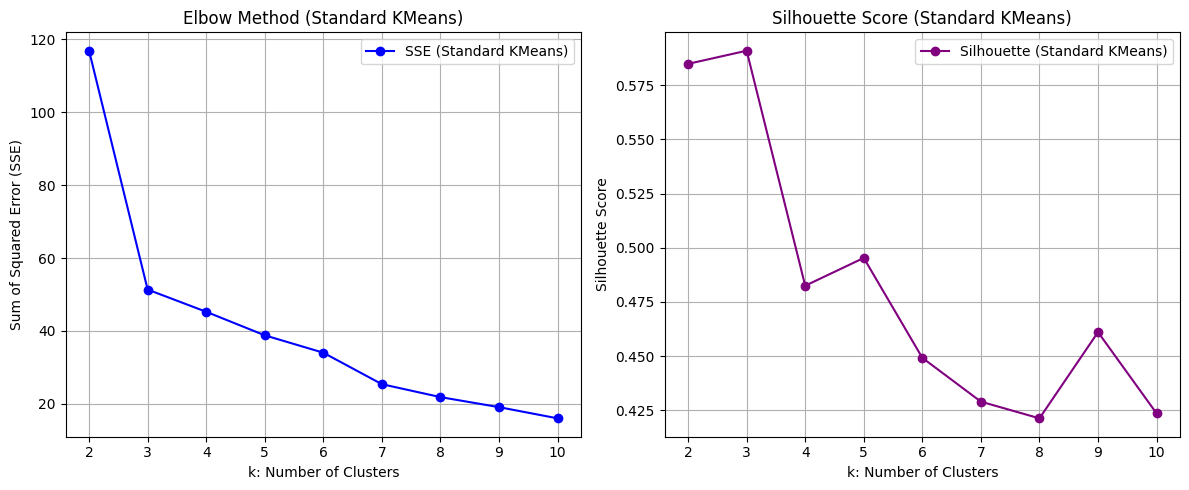

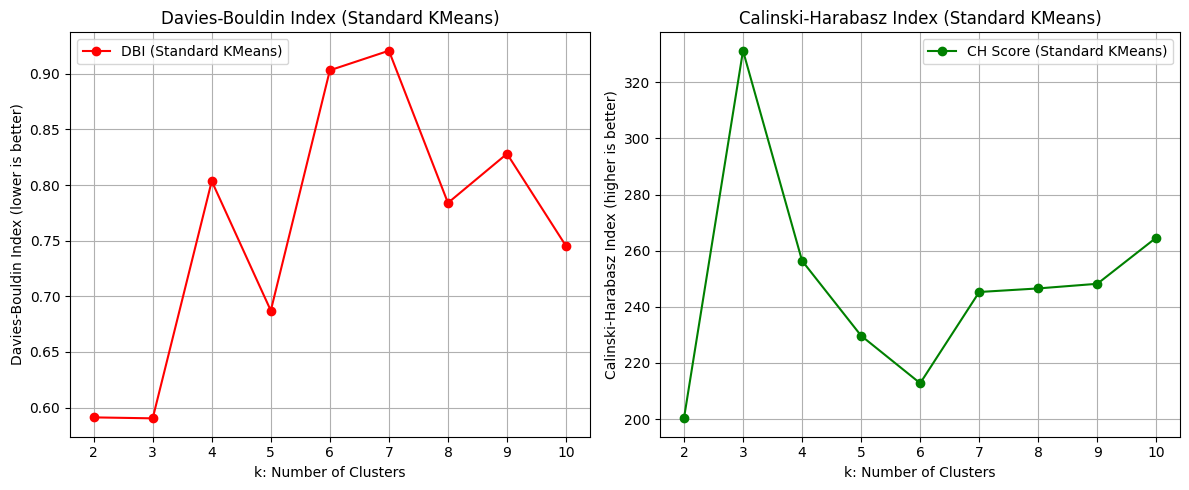

Results for Standard KMeans:
     k    sse  silhouette  davies_bouldin  calinski_harabasz
0   2 116.90        0.58            0.59             200.24
1   3  51.34        0.59            0.59             331.27
2   4  45.25        0.48            0.80             256.40
3   5  38.79        0.50            0.69             229.69
4   6  34.02        0.45            0.90             212.76
5   7  25.38        0.43            0.92             245.27
6   8  21.83        0.42            0.78             246.55
7   9  19.07        0.46            0.83             248.20
8  10  16.00        0.42            0.75             264.68


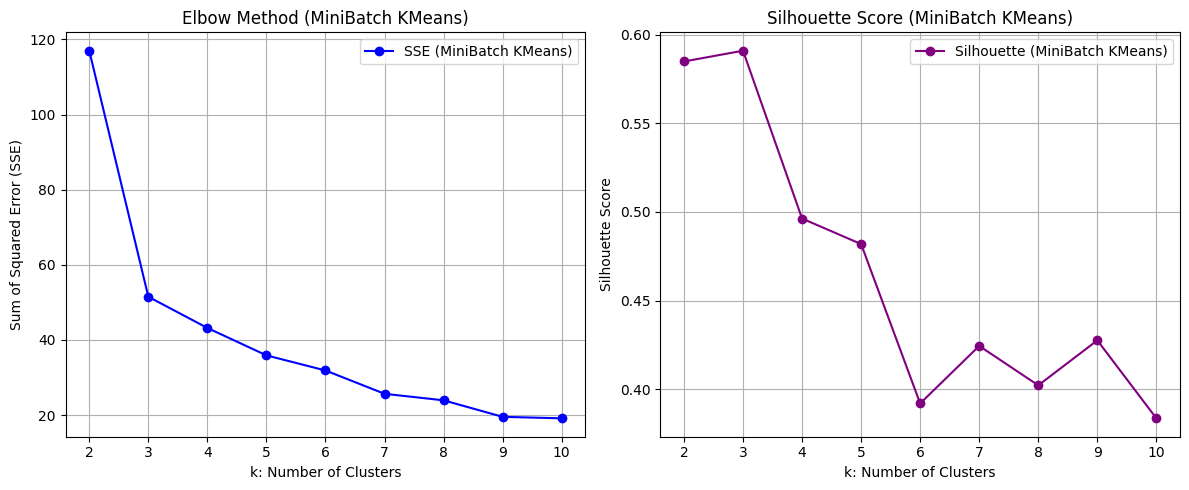

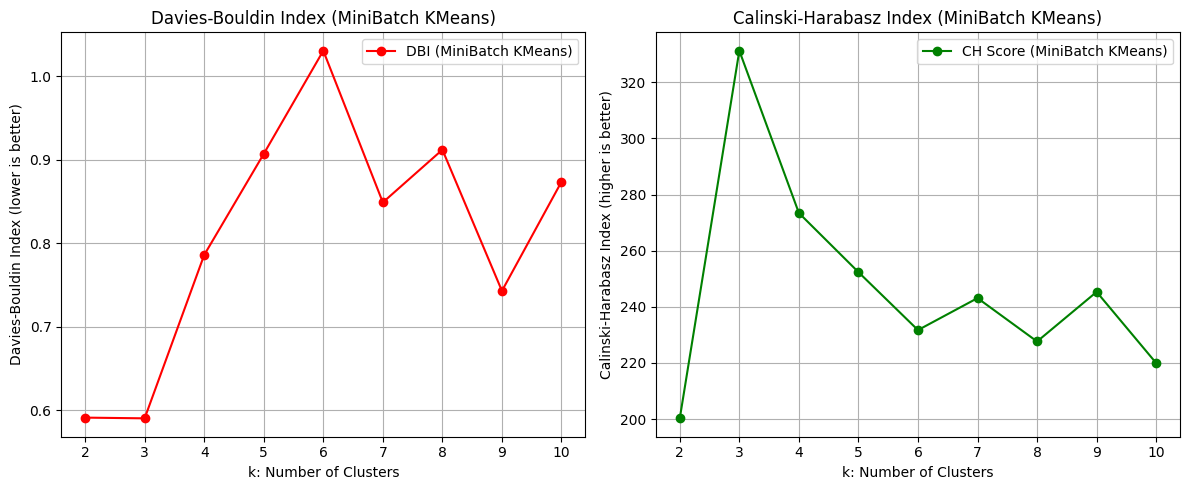

Results for MiniBatch KMeans:
     k    sse  silhouette  davies_bouldin  calinski_harabasz
0   2 117.00        0.58            0.59             200.24
1   3  51.49        0.59            0.59             331.27
2   4  43.18        0.50            0.79             273.43
3   5  35.88        0.48            0.91             252.35
4   6  31.86        0.39            1.03             231.70
5   7  25.65        0.42            0.85             243.10
6   8  23.91        0.40            0.91             227.63
7   9  19.52        0.43            0.74             245.31
8  10  19.12        0.38            0.87             219.94


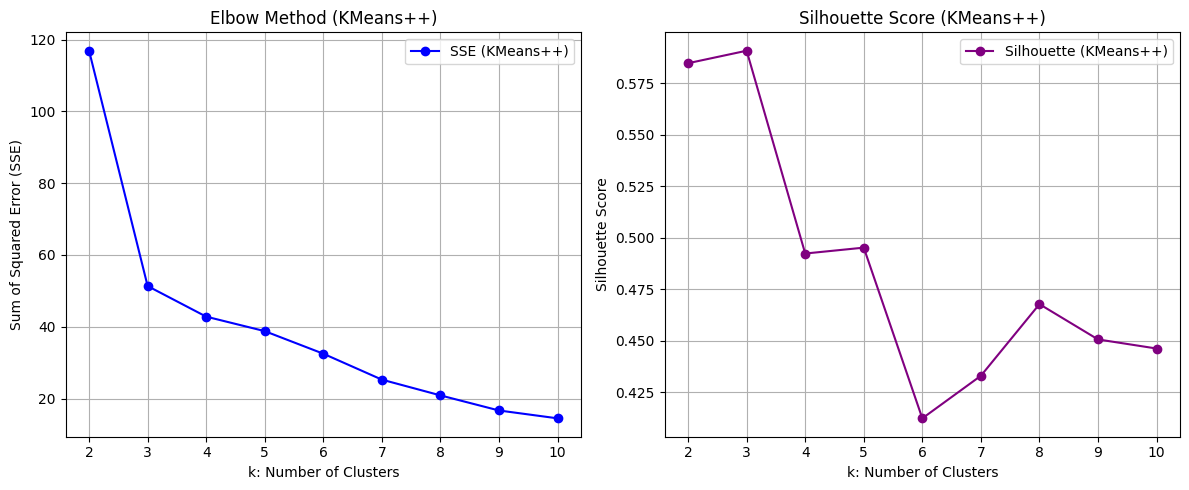

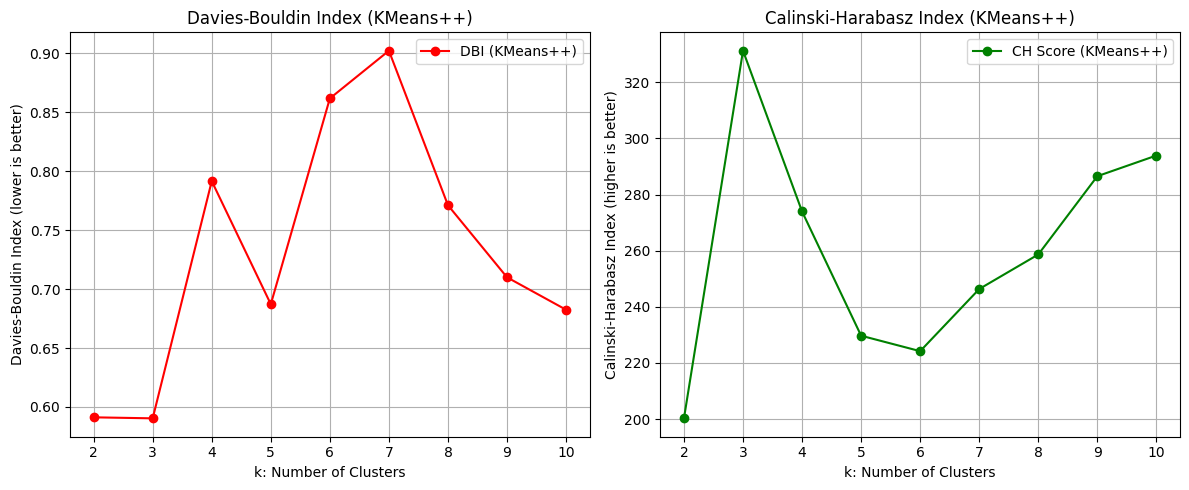

Results for KMeans++:
     k    sse  silhouette  davies_bouldin  calinski_harabasz
0   2 116.90        0.58            0.59             200.24
1   3  51.34        0.59            0.59             331.27
2   4  42.83        0.49            0.79             273.96
3   5  38.79        0.50            0.69             229.69
4   6  32.50        0.41            0.86             224.18
5   7  25.28        0.43            0.90             246.33
6   8  20.89        0.47            0.77             258.65
7   9  16.69        0.45            0.71             286.55
8  10  14.50        0.45            0.68             293.91


In [ ]:
# Function to perform clustering and evaluation for a given model
def evaluate_kmeans_model(model_name, model_class, m2, kmax=10):
    sse = {}  # Sum of Squared Errors
    sil = []  # Silhouette Scores
    dbi_scores = []  # Davies-Bouldin Index scores
    ch_scores = []   # Calinski-Harabasz Index scores

    # Store the results in a dictionary for later comparison
    results = {
        "k": list(range(2, kmax + 1)),  # Start from 2 since Silhouette/DBI/CH are undefined for k=1
        "sse": [],
        "silhouette": [],
        "davies_bouldin": [],
        "calinski_harabasz": []
    }

    # Elbow Method: SSE Calculation
    for k in range(2, kmax + 1):
        kmeans = model_class(n_clusters=k, max_iter=1000).fit(m2)
        sse[k] = kmeans.inertia_
        labels = kmeans.labels_

        # Store SSE
        results["sse"].append(kmeans.inertia_)
        # Calculate Silhouette Score
        sil.append(silhouette_score(m2, labels, metric='euclidean'))
        results["silhouette"].append(sil[-1])
        # Calculate Davies-Bouldin Index
        dbi_scores.append(davies_bouldin_score(m2, labels))
        results["davies_bouldin"].append(davies_bouldin_score(m2, labels))
        # Calculate Calinski-Harabasz Index
        ch_scores.append(calinski_harabasz_score(m2, labels))
        results["calinski_harabasz"].append(calinski_harabasz_score(m2, labels))

    # Visualization for Elbow Method and Silhouette Score
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

    # Elbow Method Plot
    ax[0].plot(list(sse.keys()), list(sse.values()), marker='o', color='b', label=f'SSE ({model_name})')
    ax[0].set_title(f'Elbow Method ({model_name})')
    ax[0].set_xlabel("k: Number of Clusters")
    ax[0].set_ylabel("Sum of Squared Error (SSE)")
    ax[0].grid(True)
    ax[0].legend()
    ax[0].set_xticks(range(2, kmax + 1))

    # Silhouette Score Plot
    ax[1].plot(range(2, kmax + 1), sil, marker='o', color='purple', label=f'Silhouette ({model_name})')
    ax[1].set_title(f'Silhouette Score ({model_name})')
    ax[1].set_xlabel("k: Number of Clusters")
    ax[1].set_ylabel("Silhouette Score")
    ax[1].grid(True)
    ax[1].legend()

    plt.tight_layout()
    plt.show()

    # Visualization for Davies-Bouldin and Calinski-Harabasz Index
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

    # Davies-Bouldin Index Plot
    ax[0].plot(range(2, kmax + 1), dbi_scores, marker='o', color='r', label=f'DBI ({model_name})')
    ax[0].set_title(f'Davies-Bouldin Index ({model_name})')
    ax[0].set_xlabel("k: Number of Clusters")
    ax[0].set_ylabel("Davies-Bouldin Index (lower is better)")
    ax[0].grid(True)
    ax[0].legend()

    # Calinski-Harabasz Index Plot
    ax[1].plot(range(2, kmax + 1), ch_scores, marker='o', color='g', label=f'CH Score ({model_name})')
    ax[1].set_title(f'Calinski-Harabasz Index ({model_name})')
    ax[1].set_xlabel("k: Number of Clusters")
    ax[1].set_ylabel("Calinski-Harabasz Index (higher is better)")
    ax[1].grid(True)
    ax[1].legend()

    plt.tight_layout()
    plt.show()

    # Return the results DataFrame
    results_df = pd.DataFrame(results)
    print(f"Results for {model_name}:\n", results_df)
    return results_df

kmax =
# 1. Standard KMeans
standard_kmeans_results = evaluate_kmeans_model("Standard KMeans", KMeans, m2, kmax=kmax)

# 2. MiniBatch KMeans
minibatch_kmeans_results = evaluate_kmeans_model("MiniBatch KMeans", MiniBatchKMeans, m2, kmax=kmax)

# 3. KMeans++
kmeans_plus_results = evaluate_kmeans_model("KMeans++", KMeans, m2, kmax=kmax)

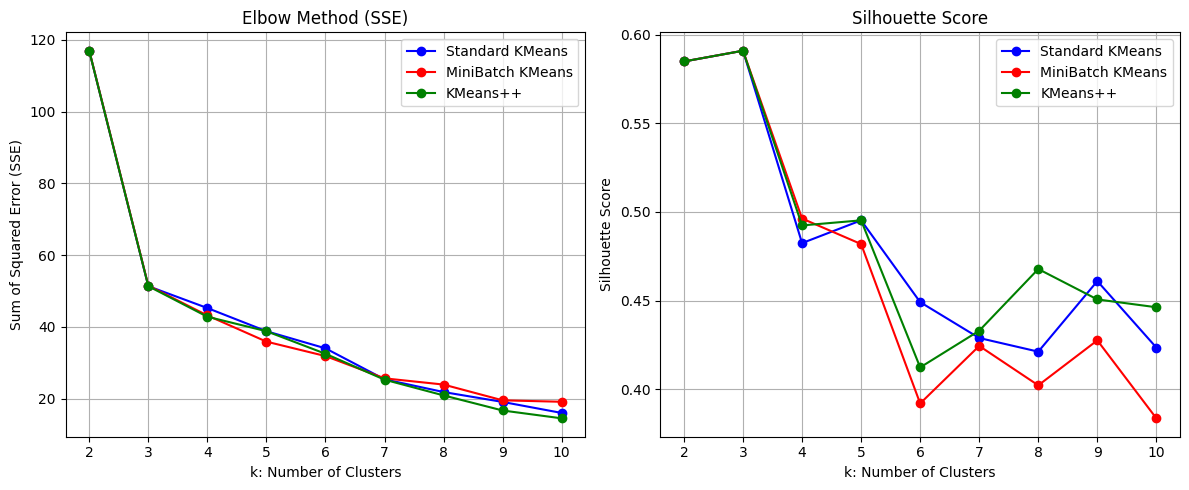

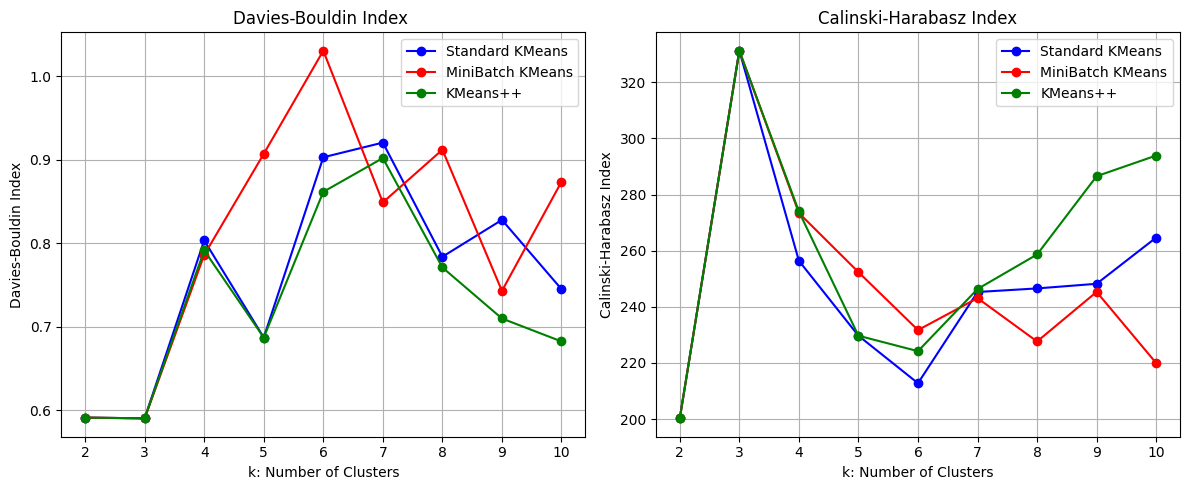

k  Standard KMeans SSE  MiniBatch KMeans SSE  KMeans++ SSE  \
0   2               123.03                123.24        123.03   
1   3                53.40                114.44         53.40   
2   4                44.77                 46.25         47.82   
3   5                37.55                 41.63         37.76   
4   6                34.09                 36.50         31.90   
5   7                32.18                 33.90         29.66   
6   8                25.54                 30.59         25.14   
7   9                23.76                 22.59         22.37   
8  10                17.10                 22.78         17.51   

   Standard KMeans Silhouette  MiniBatch KMeans Silhouette  \
0                        0.53                         0.53   
1                        0.61                         0.35   
2                        0.49                         0.59   
3                        0.47                         0.36   
4                        0.48                         0.51   
5                        0.39                         0.41   
6                        0.37                         0.37   
7                        0.38                         0.40   
8                        0.44                         0.37   

   KMeans++ Silhouette  Standard KMeans DBI  MiniBatch KMeans DBI  \
0                 0.53                 0.75                  0.75   
1                 0.61                 0.55                  1.01   
2                 0.52                 0.84                  0.74   
3                 0.48                 0.90                  1.11   
4                 0.38                 0.79                  0.80   
5                 0.39                 0.78                  0.90   
6                 0.35                 0.83                  0.88   
7                 0.39                 0.81                  0.84   
8                 0.41                 0.76                  0.96   

   KMeans++ DBI  Standard KMeans CH  MiniBatch KMeans CH  KMeans++ CH  
0          0.75              199.23               199.23       199.23  
1          0.55              335.01               112.67       335.01  
2          0.78              275.24               264.90       254.22  
3          0.89              252.43               224.37       250.75  
4          1.06              224.35               208.63       241.95  
5          0.94              198.39               189.61       217.49  
6          0.94              218.84               180.59       222.62  
7          0.79              205.98               219.21       220.04  
8          0.76              259.65               193.93       253.16

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

# Plot SSE
ax[0].plot(standard_kmeans_results['k'], standard_kmeans_results['sse'], marker='o', color='b', label='Standard KMeans')
ax[0].plot(minibatch_kmeans_results['k'], minibatch_kmeans_results['sse'], marker='o', color='r', label='MiniBatch KMeans')
ax[0].plot(kmeans_plus_results['k'], kmeans_plus_results['sse'], marker='o', color='g', label='KMeans++')
ax[0].set_title('Elbow Method (SSE)')
ax[0].set_xlabel("k: Number of Clusters")
ax[0].set_ylabel("Sum of Squared Error (SSE)")
ax[0].grid(True)
ax[0].legend()

# Plot Silhouette Score
ax[1].plot(standard_kmeans_results['k'], standard_kmeans_results['silhouette'], marker='o', color='b', label='Standard KMeans')
ax[1].plot(minibatch_kmeans_results['k'], minibatch_kmeans_results['silhouette'], marker='o', color='r', label='MiniBatch KMeans')
ax[1].plot(kmeans_plus_results['k'], kmeans_plus_results['silhouette'], marker='o', color='g', label='KMeans++')
ax[1].set_title('Silhouette Score')
ax[1].set_xlabel("k: Number of Clusters")
ax[1].set_ylabel("Silhouette Score")
ax[1].grid(True)
ax[1].legend()

plt.tight_layout()
plt.show()

# Plot Davies-Bouldin Index and Calinski-Harabasz Index
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

# Plot Davies-Bouldin Index
ax[0].plot(standard_kmeans_results['k'], standard_kmeans_results['davies_bouldin'], marker='o', color='b', label='Standard KMeans')
ax[0].plot(minibatch_kmeans_results['k'], minibatch_kmeans_results['davies_bouldin'], marker='o', color='r', label='MiniBatch KMeans')
ax[0].plot(kmeans_plus_results['k'], kmeans_plus_results['davies_bouldin'], marker='o', color='g', label='KMeans++')
ax[0].set_title('Davies-Bouldin Index ')
ax[0].set_xlabel("k: Number of Clusters")
ax[0].set_ylabel("Davies-Bouldin Index")
ax[0].grid(True)
ax[0].legend()

# Plot Calinski-Harabasz Index
ax[1].plot(standard_kmeans_results['k'], standard_kmeans_results['calinski_harabasz'], marker='o', color='b', label='Standard KMeans')
ax[1].plot(minibatch_kmeans_results['k'], minibatch_kmeans_results['calinski_harabasz'], marker='o', color='r', label='MiniBatch KMeans')
ax[1].plot(kmeans_plus_results['k'], kmeans_plus_results['calinski_harabasz'], marker='o', color='g', label='KMeans++')
ax[1].set_title('Calinski-Harabasz Index')
ax[1].set_xlabel("k: Number of Clusters")
ax[1].set_ylabel("Calinski-Harabasz Index")
ax[1].grid(True)
ax[1].legend()

plt.tight_layout()
plt.show()

comparison_df


A sharp drop in SSE at k=3 indicates that three clusters provide the best balance between compactness and simplicity, according to the Elbow Method. As k increases beyond 3, the score declines, suggesting that more clusters lead to overfitting.

The Silhouette Score evaluates how well-separated the clusters are. At k=3, the score peaks at 0.59 for all methods, indicating strong separation between clusters. However, as k increases beyond 3, the score declines, suggesting that additional clusters could lead to overfitting and poor separation.  

The Davies-Bouldin Index, which measures the similarity between, reaches its lowest value of 0.59 at k=3. MiniBatch KMeans shows more fluctuations at higher k values, while Standard KMeans and KMeans++ exhibit more stable performance.  

The Calinski-Harabasz Index assesses the ratio of variance between clusters to the variance within clusters. At k=3, the index peaks at 331.27 for all methods. KMeans++ maintains the highest scores for larger k values, showing better separation across clusters compared to Standard and MiniBatch KMeans.  

In conclusion, **k=3 is the optimal choice**, offering clear and interpretable clusters. Among the methods, KMeans++ is the most reliable for clustering countries, making it ideal for HELP International's aid allocation strategy.

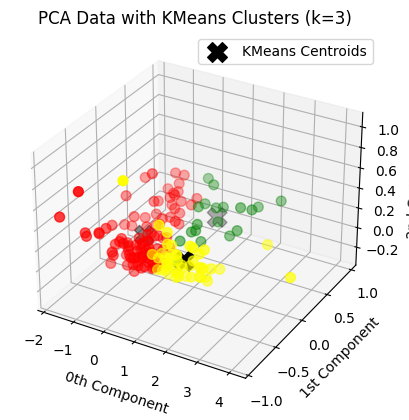

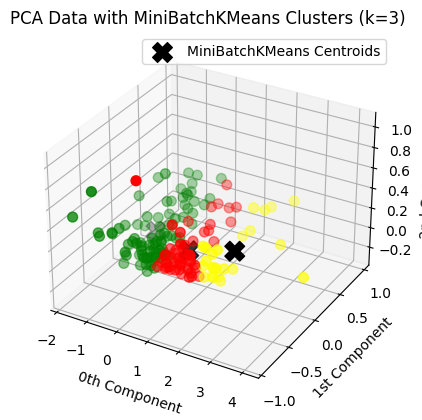

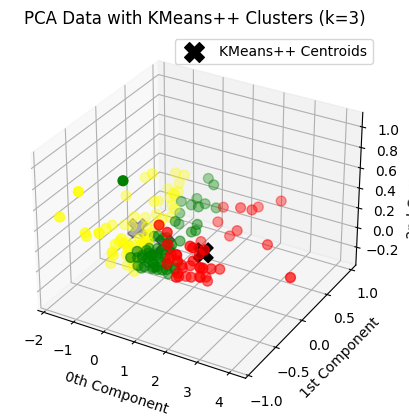

In [ ]:
# Function to apply KMeans-based models
def apply_kmeans_model(model_class, model_name, m2, data, pca_df2):
    model = model_class(n_clusters=3, init='k-means++', max_iter=1000)
    model.fit(m2)

    centroids = model.cluster_centers_
    labels = model.labels_

    data[f'{model_name}_Class'] = labels
    pca_df2[f'{model_name}_Class'] = labels

    colors = np.array(['red', 'green', 'yellow'])

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    ax.scatter(centroids[:, 0], centroids[:, 1], centroids[:, 2], marker="X", color='black', s=200, label=f'{model_name} Centroids')

    ax.scatter(m2[:, 0], m2[:, 1], m2[:, 2], c=colors[labels], s=50)

    plt.title(f'PCA Data with {model_name} Clusters (k=3)')
    ax.set_xlabel('0th Component')
    ax.set_ylabel('1st Component')
    ax.set_zlabel('2nd Component')
    plt.legend()
    plt.show()

apply_kmeans_model(KMeans, 'KMeans', m2, data, pca_df2)
apply_kmeans_model(MiniBatchKMeans, 'MiniBatchKMeans', m2, data, pca_df2)
apply_kmeans_model(KMeans, 'KMeans++', m2, data, pca_df2)

The above 3D PCA plots compare standard KMeans, MiniBatchKMeans, and KMeans++ clustering. KMeans++ provides the best cluster separation due to improved centroid initialization. MiniBatchKMeans is faster but shows less distinct clusters. Standard KMeans performs well but lacks the clarity of KMeans++.  

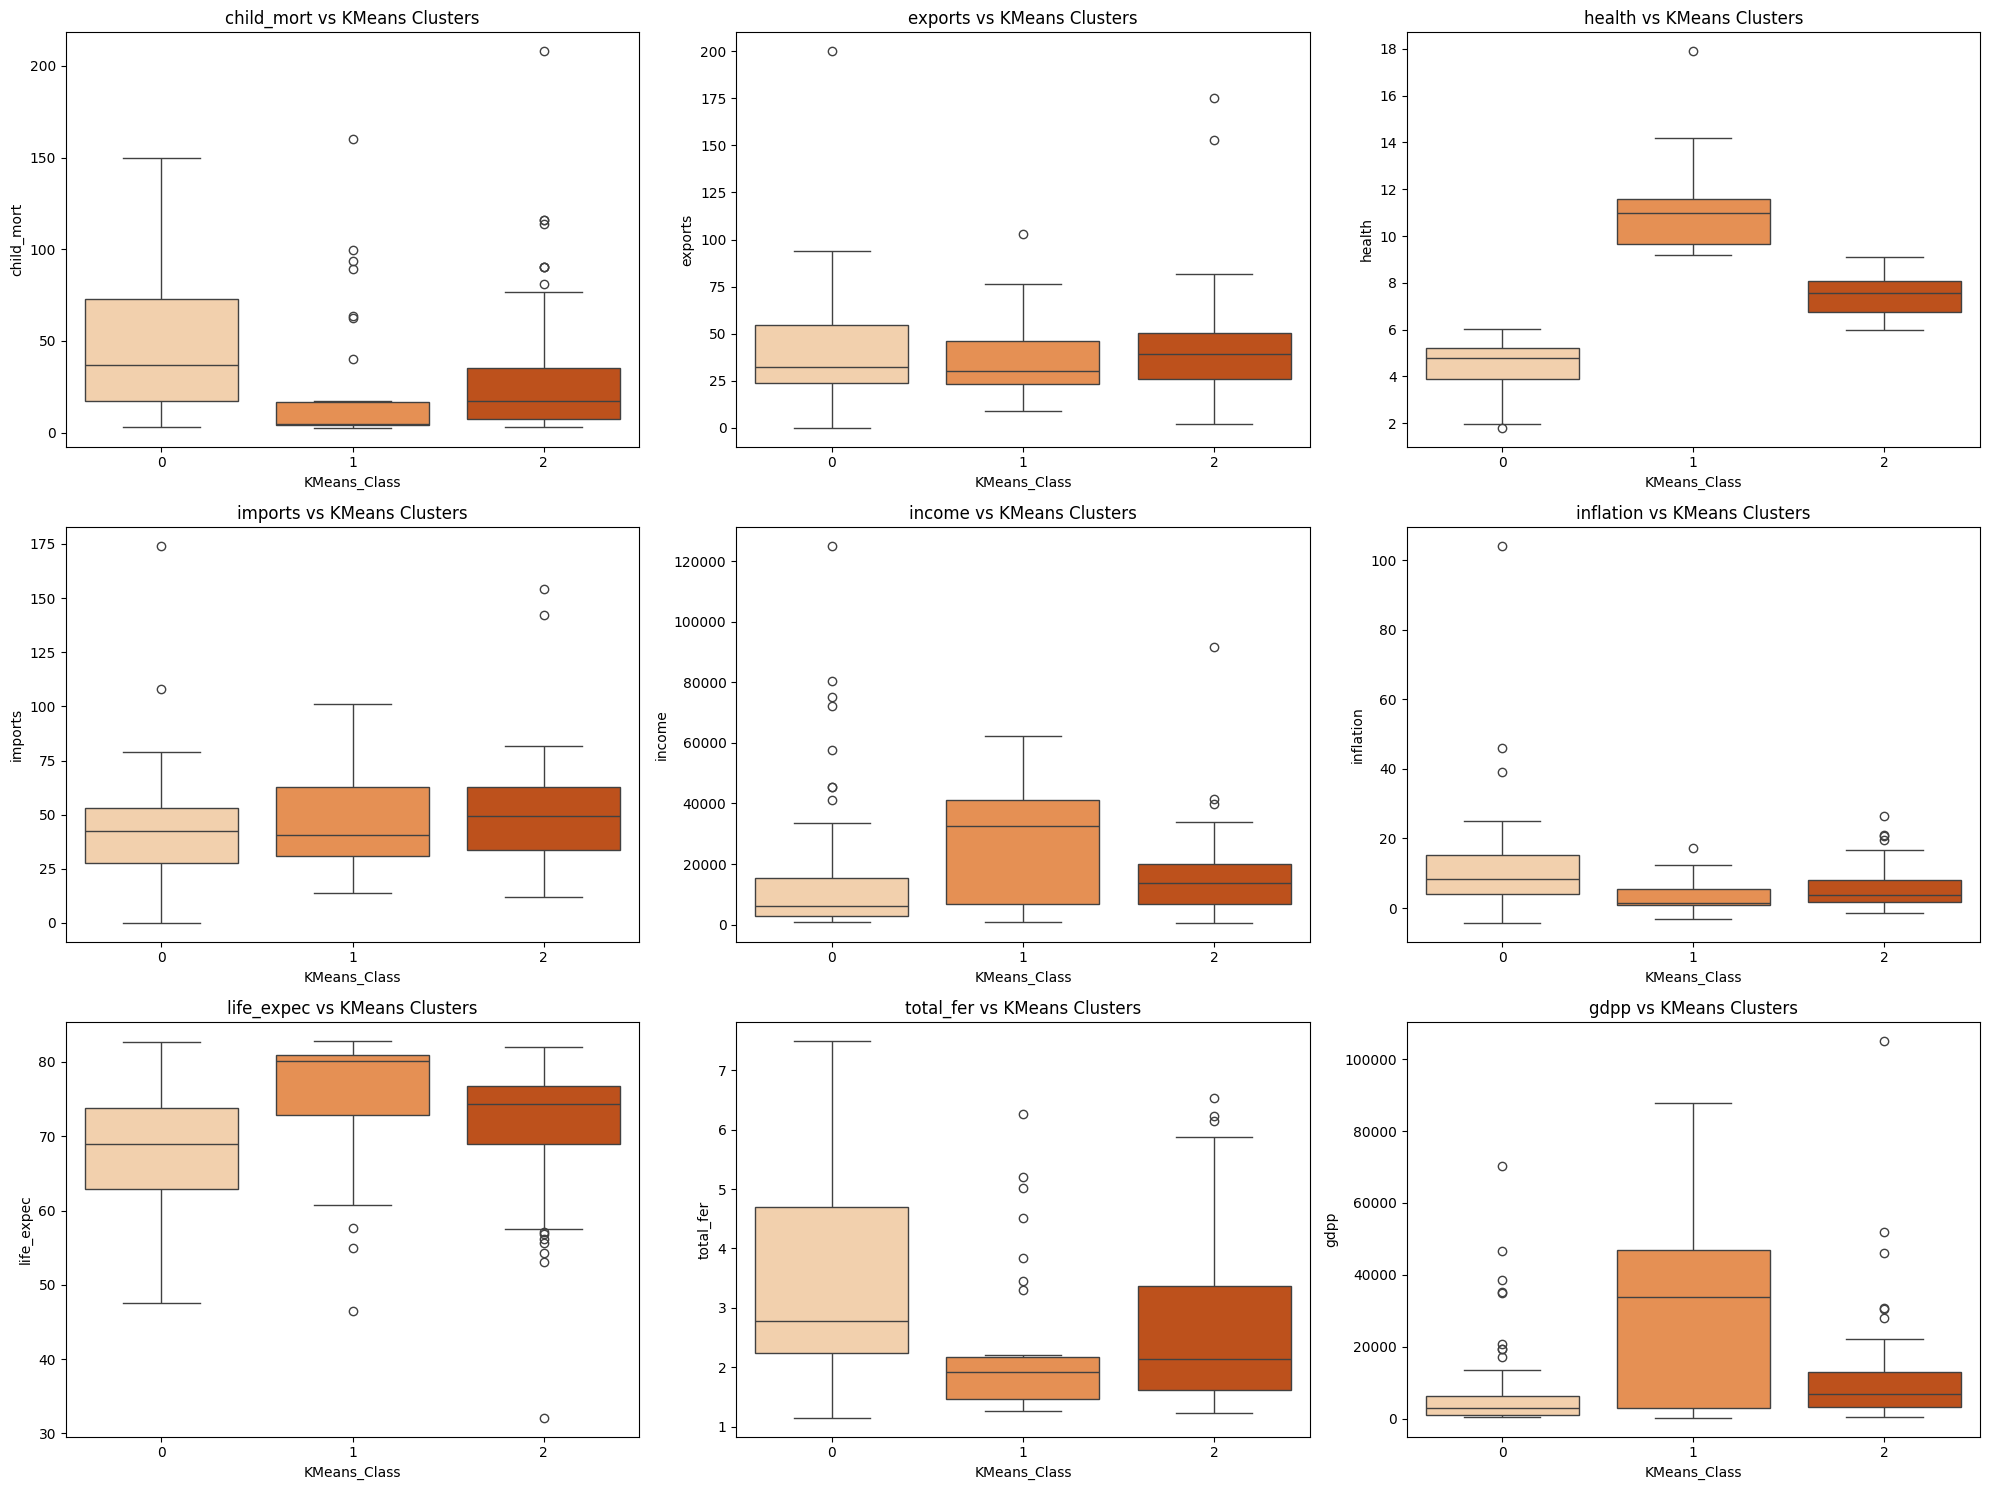

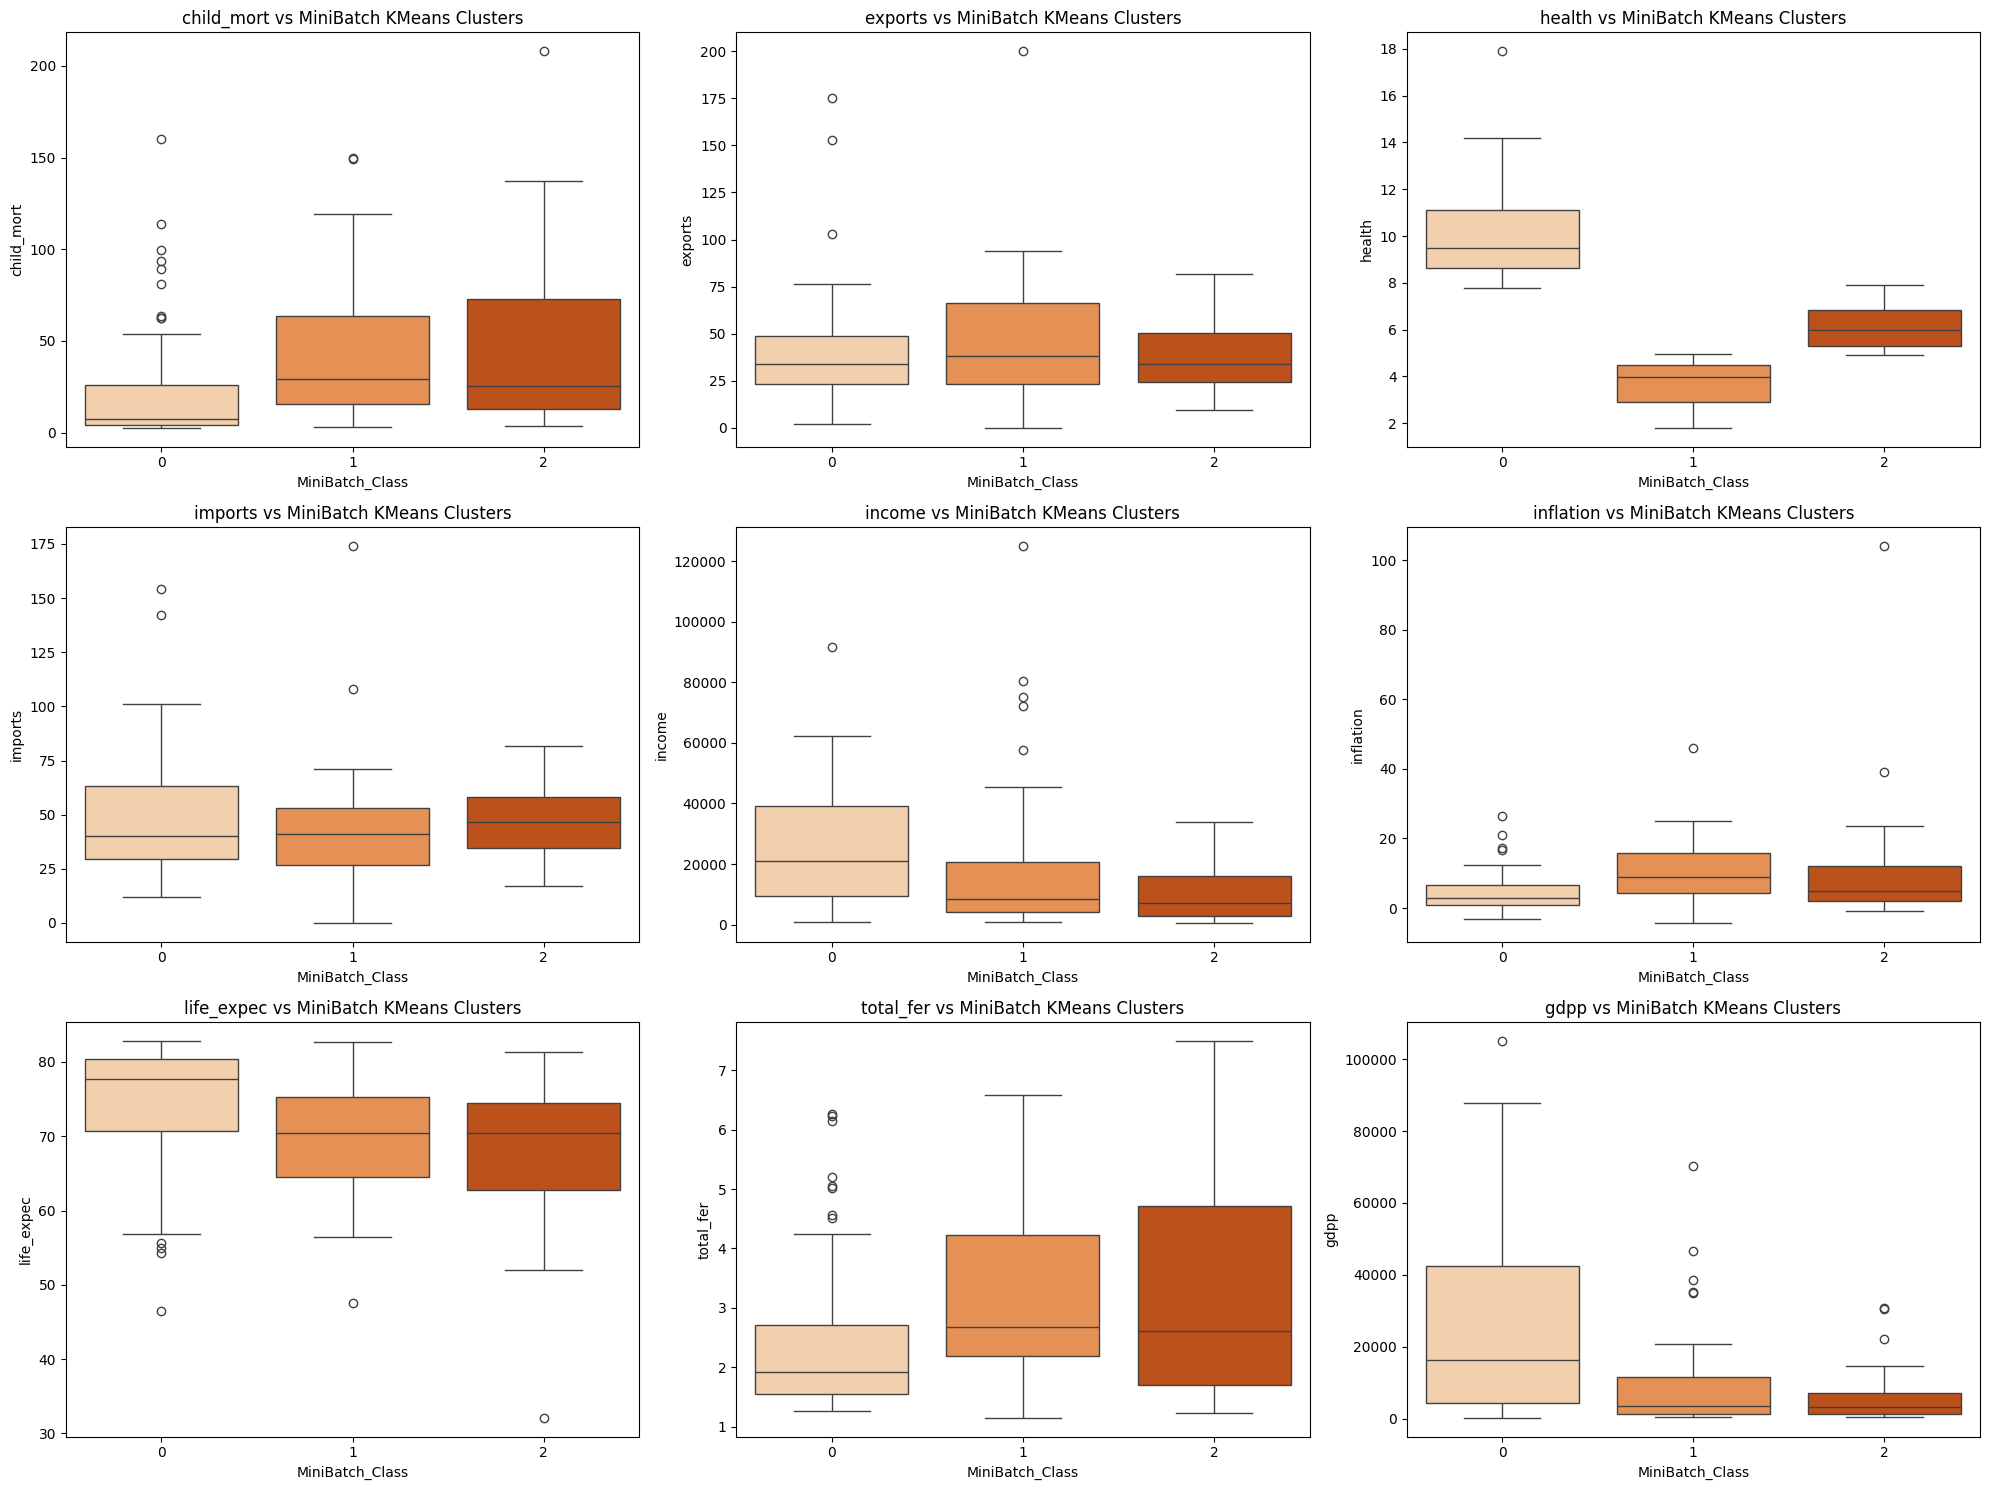

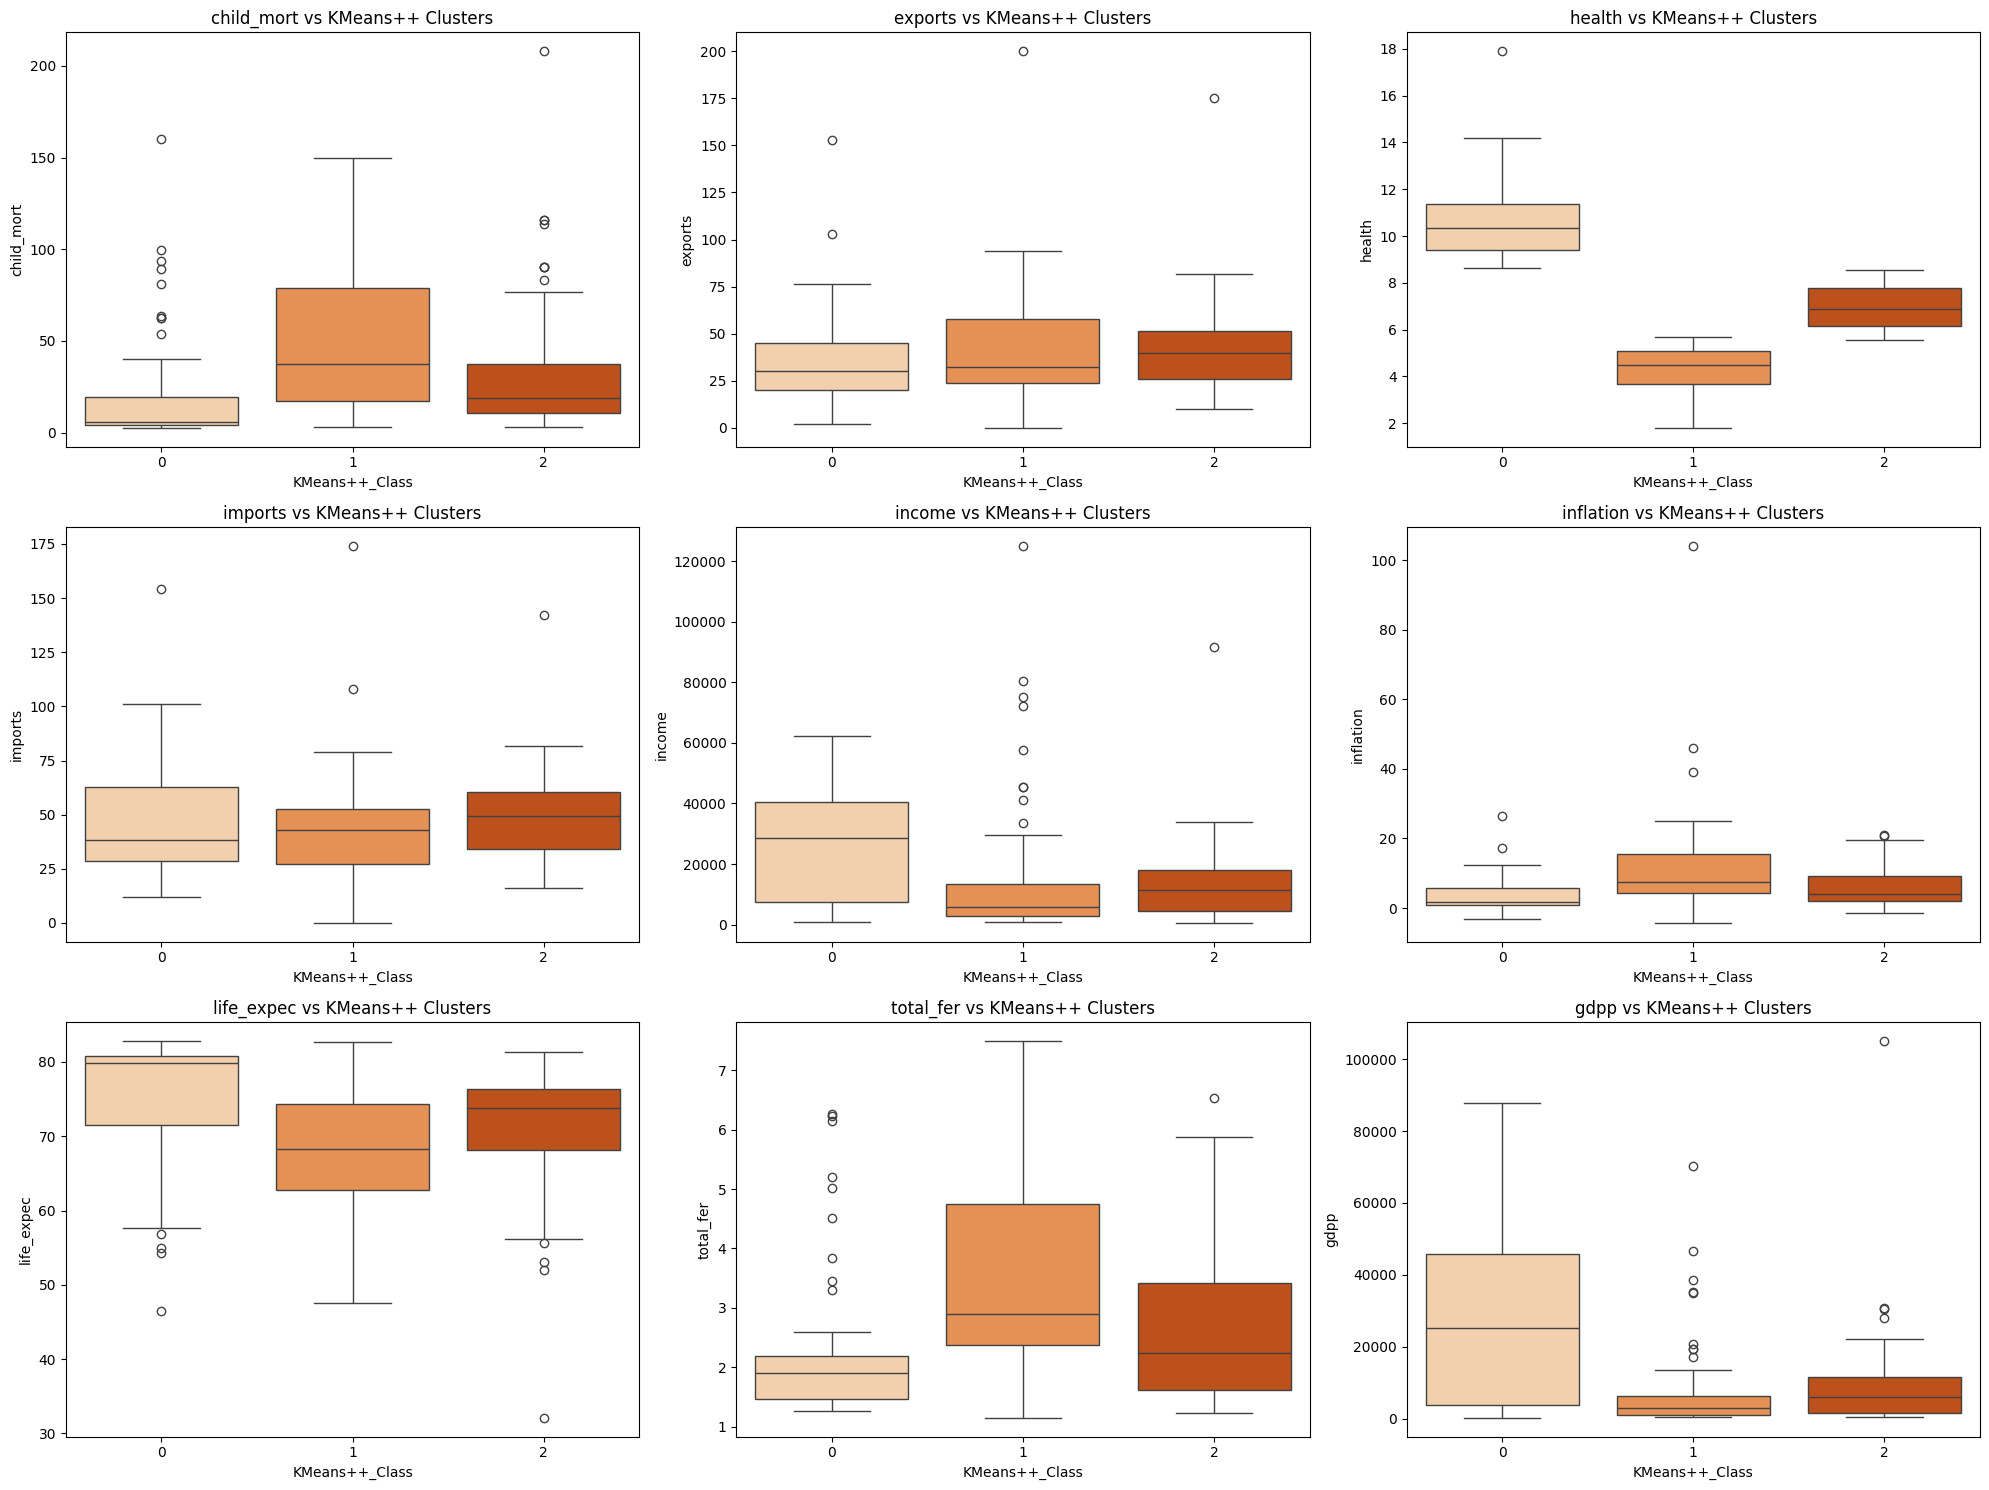

In [ ]:
kmeans_model = KMeans(n_clusters=3, init='k-means++', max_iter=1000)
kmeans_model.fit(m2)
data['KMeans_Class'] = kmeans_model.labels_

minibatch_model = MiniBatchKMeans(n_clusters=3, init='k-means++', max_iter=1000)
minibatch_model.fit(m2)
data['MiniBatch_Class'] = minibatch_model.labels_

kmeans_plus_model = KMeans(n_clusters=3, init='k-means++', max_iter=1000)
kmeans_plus_model.fit(m2)
data['KMeans++_Class'] = kmeans_plus_model.labels_

attributes = ['child_mort', 'exports', 'health', 'imports', 'income', 'inflation', 'life_expec', 'total_fer', 'gdpp']

def plot_boxplots(data, class_column, model_name):
    fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(20, 15))
    axes = axes.flatten()

    for i, attribute in enumerate(attributes):
        sns.boxplot(x=class_column, y=attribute, data=data, palette='Oranges', ax=axes[i])
        axes[i].set_title(f'{attribute} vs {model_name} Clusters')

    plt.tight_layout()
    plt.show()

plot_boxplots(data, 'KMeans_Class', 'KMeans')

plot_boxplots(data, 'MiniBatch_Class', 'MiniBatch KMeans')

plot_boxplots(data, 'KMeans++_Class', 'KMeans++')

In [ ]:
pca_df2['Country'] = data['country']

pca_df2['KMeans_Class'] = pca_df2['KMeans_Class'].map({
    0: 'Might Need Help',
    1: 'Help Needed',
    2: 'No Help Needed'
})

fig = px.choropleth(pca_df2[['Country', 'KMeans_Class']],
                    locationmode='country names',
                    locations='Country',
                    title='Needed Help Per Country (World) - KMeans',
                    color=pca_df2['KMeans_Class'],
                    color_discrete_map={
                        'Help Needed': 'Red',
                        'Might Need Help': 'Yellow',
                        'No Help Needed': 'Green'
                    })
fig.update_geos(fitbounds="locations", visible=True)
fig.update_layout(legend_title_text='Labels', legend_title_side='top', title_pad_l=260, title_y=0.86)
fig.show(engine='kaleido')

In [ ]:
minibatch_model = MiniBatchKMeans(n_clusters=3, batch_size=100, max_iter=1000)
minibatch_model.fit(m2)

pca_df2['MiniBatch_Class'] = minibatch_model.labels_

pca_df2['MiniBatch_Class'] = pca_df2['MiniBatch_Class'].map({
    0: 'Might Need Help',
    1: 'No Help Needed',
    2: 'Help Needed'
})

fig = px.choropleth(pca_df2[['Country', 'MiniBatch_Class']],
                    locationmode='country names',
                    locations='Country',
                    title='Needed Help Per Country (World) - MiniBatch KMeans',
                    color=pca_df2['MiniBatch_Class'],
                    color_discrete_map={
                        'Help Needed': 'Red',
                        'Might Need Help': 'Yellow',
                        'No Help Needed': 'Green'
                    })
fig.update_geos(fitbounds="locations", visible=True)
fig.update_layout(legend_title_text='Labels', legend_title_side='top', title_pad_l=260, title_y=0.86)
fig.show(engine='kaleido')

In [ ]:
pca_df2['KMeans++_Class'] = pca_df2['KMeans++_Class'].map({
    0: 'No Help Needed',
    1: 'Help Needed',
    2: 'Might Need Help'
})

fig = px.choropleth(pca_df2[['Country', 'KMeans++_Class']],
                    locationmode='country names',
                    locations='Country',
                    title='Needed Help Per Country (World) - KMeans++',
                    color=pca_df2['KMeans++_Class'],
                    color_discrete_map={
                        'Help Needed': 'Red',
                        'Might Need Help': 'Yellow',
                        'No Help Needed': 'Green'
                    })
fig.update_geos(fitbounds="locations", visible=True)
fig.update_layout(legend_title_text='Labels', legend_title_side='top', title_pad_l=260, title_y=0.86)
fig.show(engine='kaleido')

## Agglomerative Clustering

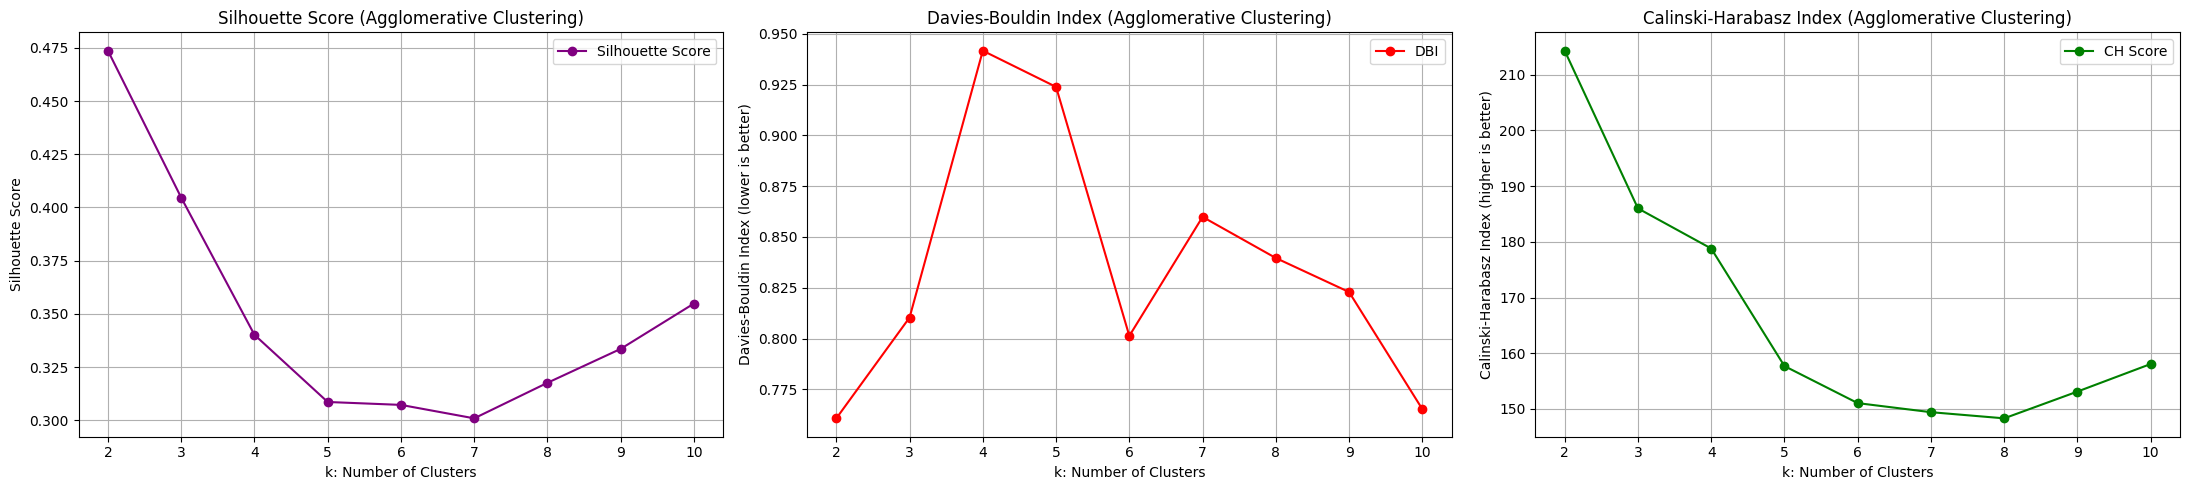

    k  silhouette  davies_bouldin  calinski_harabasz
0   2        0.47            0.76             214.32
1   3        0.40            0.81             186.00
2   4        0.34            0.94             178.80
3   5        0.31            0.92             157.69
4   6        0.31            0.80             151.04
5   7        0.30            0.86             149.41
6   8        0.32            0.84             148.30
7   9        0.33            0.82             153.11
8  10        0.35            0.77             158.06


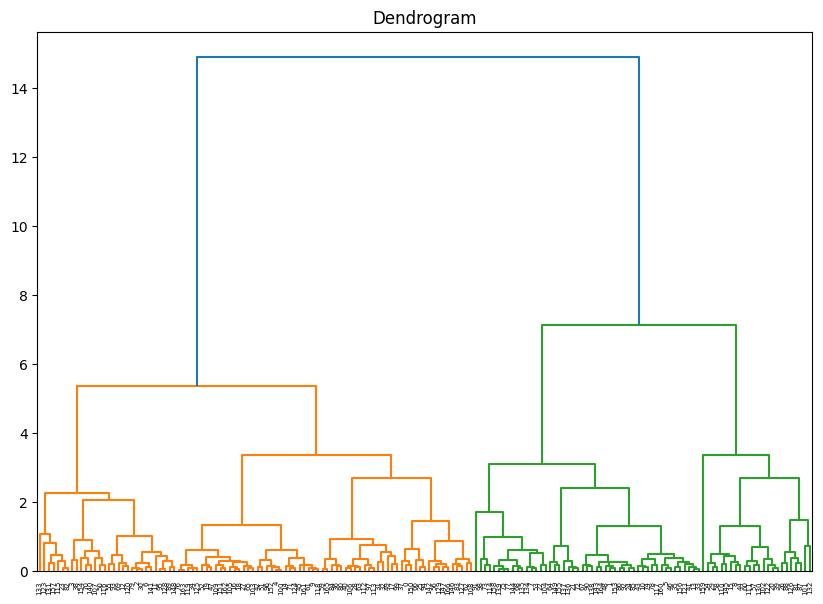

In [ ]:
# Perform Agglomerative Clustering
def evaluate_hierarchical_clustering(m2, kmax=10):
    sil = []  # Silhouette Scores
    dbi_scores = []  # Davies-Bouldin Index scores
    ch_scores = []   # Calinski-Harabasz Index scores

    results = {
        "k": list(range(2, kmax + 1)),  # Start from 2
        "silhouette": [],
        "davies_bouldin": [],
        "calinski_harabasz": [],
    }

    # Perform clustering and evaluate
    for k in range(2, kmax + 1):
        model = AgglomerativeClustering(n_clusters=k, metric='euclidean', linkage='ward')
        labels = model.fit_predict(m2)

        sil.append(silhouette_score(m2, labels, metric='euclidean'))
        results["silhouette"].append(sil[-1])

        dbi_scores.append(davies_bouldin_score(m2, labels))
        results["davies_bouldin"].append(davies_bouldin_score(m2, labels))

        ch_scores.append(calinski_harabasz_score(m2, labels))
        results["calinski_harabasz"].append(calinski_harabasz_score(m2, labels))

    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(22, 5))

    ax[0].plot(range(2, kmax + 1), sil, marker='o', color='purple', label='Silhouette Score')
    ax[0].set_title('Silhouette Score (Agglomerative Clustering)')
    ax[0].set_xlabel("k: Number of Clusters")
    ax[0].set_ylabel("Silhouette Score")
    ax[0].grid(True)
    ax[0].legend()

    ax[1].plot(range(2, kmax + 1), dbi_scores, marker='o', color='r', label='DBI')
    ax[1].set_title('Davies-Bouldin Index (Agglomerative Clustering)')
    ax[1].set_xlabel("k: Number of Clusters")
    ax[1].set_ylabel("Davies-Bouldin Index (lower is better)")
    ax[1].grid(True)
    ax[1].legend()

    ax[2].plot(range(2, kmax + 1), ch_scores, marker='o', color='g', label='CH Score')
    ax[2].set_title('Calinski-Harabasz Index (Agglomerative Clustering)')
    ax[2].set_xlabel("k: Number of Clusters")
    ax[2].set_ylabel("Calinski-Harabasz Index (higher is better)")
    ax[2].grid(True)
    ax[2].legend()

    plt.tight_layout()
    plt.show()

    results_df = pd.DataFrame(results)
    return results_df

hierarchical_results = evaluate_hierarchical_clustering(m2)
print(hierarchical_results)

plt.figure(figsize=(10, 7))
dendrogram(linkage(m2, method='ward'))
plt.title('Dendrogram')
plt.show()


The dendrogram shows the largest vertical distance at k=2, indicating a natural separation of the data into two clusters. However, **choosing k=3 is more practical** for HELP International’s needs, as it allows for a finer classification of countries into three categories—those in urgent need of aid, those moderately in need, and those that do not require immediate assistance. This better aligns with the goal of distributing aid based on varying levels of socio-economic and health conditions.

In [ ]:
from scipy.cluster.hierarchy import fcluster
from scipy.spatial.distance import pdist, squareform

# Function to evaluate clustering using different metrics
def evaluate_hierarchical_clustering(linkage_method, metric, m2, n_clusters=3):
    if metric != 'euclidean':
        # Compute the pairwise distances
        pairwise_dist = pdist(m2, metric=metric)
        # Convert the pairwise distances to a square matrix
        dist_matrix = squareform(pairwise_dist)
        # Perform hierarchical clustering
        Z = linkage(dist_matrix, method=linkage_method)
    else:
        Z = linkage(m2, method=linkage_method, metric=metric)

    labels = fcluster(Z, t=n_clusters, criterion='maxclust')

    silhouette_avg = silhouette_score(m2, labels, metric=metric)
    db_index = davies_bouldin_score(m2, labels)
    ch_index = calinski_harabasz_score(m2, labels)

    return silhouette_avg, db_index, ch_index

linkage_methods = ['ward', 'complete', 'average', 'single']
distance_metrics = ['euclidean', 'cityblock', 'cosine', 'chebyshev']

n_clusters = 3

results = []

for linkage_method in linkage_methods:
    for metric in distance_metrics:
        if linkage_method == 'ward' and metric != 'euclidean':
            continue

        try:
            silhouette_avg, db_index, ch_index = evaluate_hierarchical_clustering(linkage_method, metric, m2, n_clusters)

            results.append({
                'linkage_method': linkage_method,
                'distance_metric': metric,
                'silhouette_score': silhouette_avg,
                'davies_bouldin_index': db_index,
                'calinski_harabasz_index': ch_index
            })
        except ValueError as e:
            print(f"Skipping combination {linkage_method}-{metric} due to error: {e}")

results_df = pd.DataFrame(results)

print(results_df)


   linkage_method distance_metric  silhouette_score  davies_bouldin_index  \
0            ward       euclidean              0.40                  0.81   
1        complete       euclidean              0.30                  0.90   
2        complete       cityblock              0.25                  0.74   
3        complete          cosine              0.65                  1.31   
4        complete       chebyshev              0.47                  0.49   
5         average       euclidean              0.46                  0.58   
6         average       cityblock              0.42                  0.71   
7         average          cosine              0.68                  0.89   
8         average       chebyshev              0.53                  0.55   
9          single       euclidean              0.26                  0.49   
10         single       cityblock              0.38                  0.49   
11         single          cosine             -0.22                  4.30   

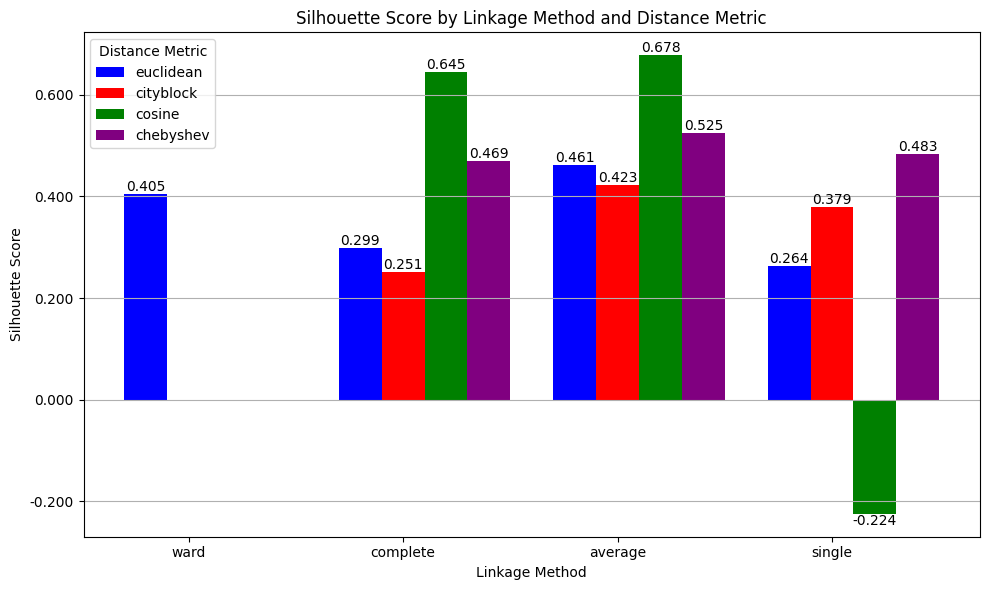

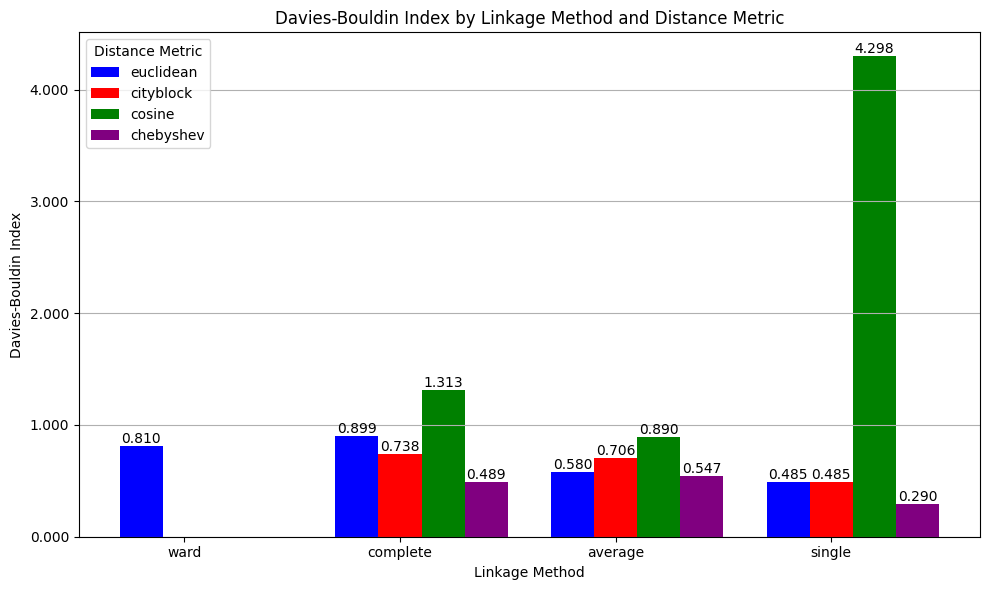

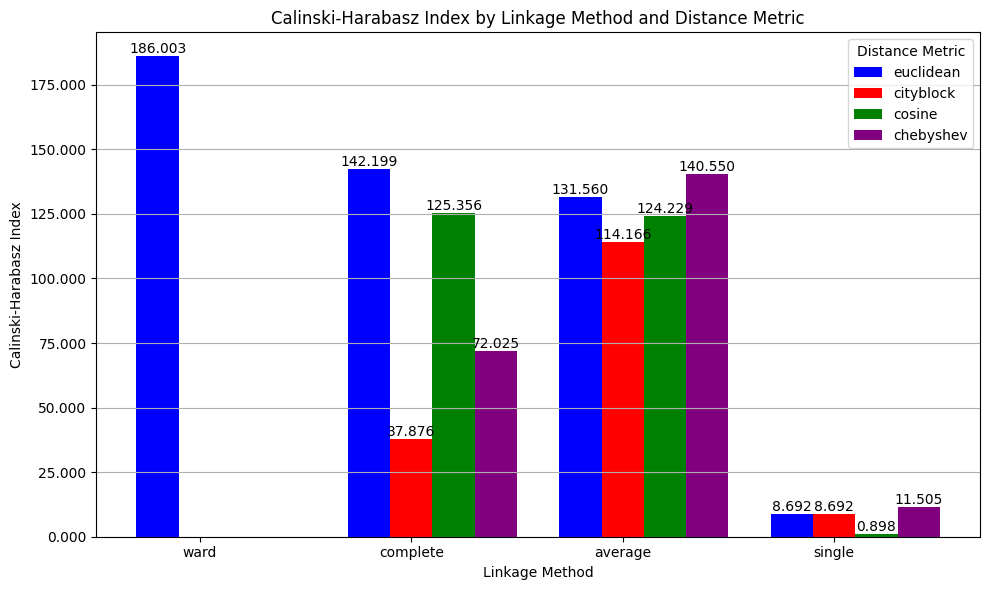

In [ ]:
bar_width = 0.2
positions = np.arange(len(linkage_methods))

distance_colors = {'Euclidean': 'blue', 'Cityblock': 'red', 'Cosine': 'green', 'Chebyshev': 'purple'}

fig, ax = plt.subplots(figsize=(10, 6))
for i, metric in enumerate(distance_metrics):
    metric_data = results_df[results_df['distance_metric'] == metric.capitalize()]

    for idx, method in enumerate(linkage_methods):
        method_data = metric_data[metric_data['linkage_method'] == method]
        if not method_data.empty:
            adjusted_position = positions[idx] + i * bar_width
            ax.bar(adjusted_position, method_data['silhouette_score'].values[0],
                   width=bar_width, color=distance_colors[metric.capitalize()], label=metric)

ax.set_xlabel('Linkage Method')
ax.set_ylabel('Silhouette Score')
ax.set_title('Silhouette Score by Linkage Method and Distance Metric')

ax.set_xticks(positions + bar_width)
ax.set_xticklabels(linkage_methods)

handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys(), title='Distance Metric', loc='upper left')

for container in ax.containers:
    ax.bar_label(container, fmt='%.3f')

ax.yaxis.grid(True)
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.3f}'))

plt.tight_layout()
plt.show()

fig, ax = plt.subplots(figsize=(10, 6))
for i, metric in enumerate(distance_metrics):
    metric_data = results_df[results_df['distance_metric'] == metric.capitalize()]  # Ensure correct capitalization

    for idx, method in enumerate(linkage_methods):
        method_data = metric_data[metric_data['linkage_method'] == method]
        if not method_data.empty:
            adjusted_position = positions[idx] + i * bar_width
            ax.bar(adjusted_position, method_data['davies_bouldin_index'].values[0],
                   width=bar_width, color=distance_colors[metric.capitalize()], label=metric)

ax.set_xlabel('Linkage Method')
ax.set_ylabel('Davies-Bouldin Index')
ax.set_title('Davies-Bouldin Index by Linkage Method and Distance Metric')

ax.set_xticks(positions + bar_width)
ax.set_xticklabels(linkage_methods)

handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys(), title='Distance Metric', loc='upper left')

for container in ax.containers:
    ax.bar_label(container, fmt='%.3f')

ax.yaxis.grid(True)
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.3f}'))

plt.tight_layout()
plt.show()

fig, ax = plt.subplots(figsize=(10, 6))
for i, metric in enumerate(distance_metrics):
    metric_data = results_df[results_df['distance_metric'] == metric.capitalize()]

    for idx, method in enumerate(linkage_methods):
       method_data = metric_data[metric_data['linkage_method'] == method]
       if not method_data.empty:
            adjusted_position = positions[idx] + i * bar_width
            ax.bar(adjusted_position, method_data['calinski_harabasz_index'].values[0],
                   width=bar_width, color=distance_colors[metric.capitalize()], label=metric)

ax.set_xlabel('Linkage Method')
ax.set_ylabel('Calinski-Harabasz Index')
ax.set_title('Calinski-Harabasz Index by Linkage Method and Distance Metric')

ax.set_xticks(positions + bar_width)
ax.set_xticklabels(linkage_methods)

handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys(), title='Distance Metric', loc='upper right')

for container in ax.containers:
    ax.bar_label(container, fmt='%.3f')

ax.yaxis.grid(True)
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.3f}'))

plt.tight_layout()
plt.show()

From these metrics, the following methods performed the best:
*   Ward-Euclidean: Produced compact clusters with the highest Calinski-Harabasz Index (186.0), suggesting clear separation between clusters.
*   Average-Cosine: Achieved the highest Silhouette Score (0.678), indicating that clusters were well-defined and distinct.
*   Complete-Cosine and Average-Chebyshev: Also showed good overall performance.

In contrast, Single Linkage performed poorly, forming loose clusters that hinder accurate classification and aid targeting.

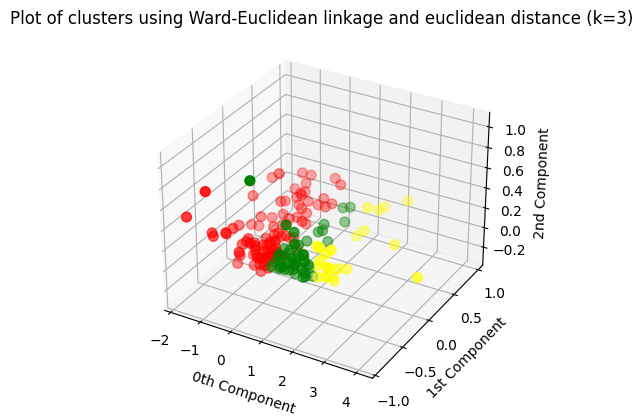

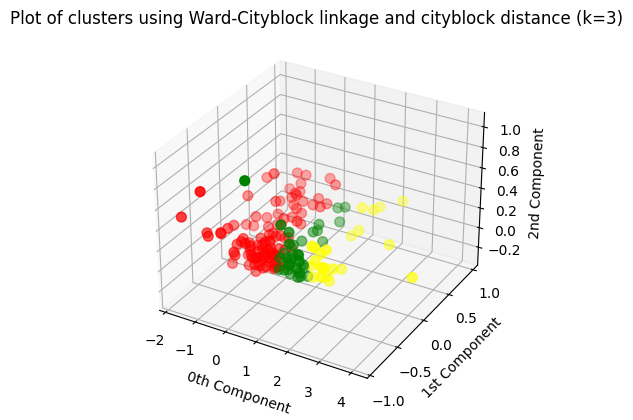

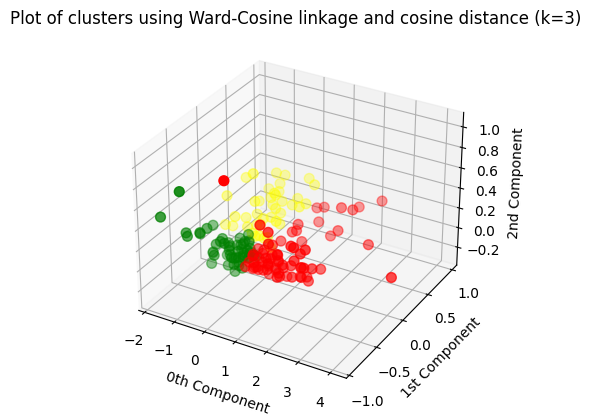

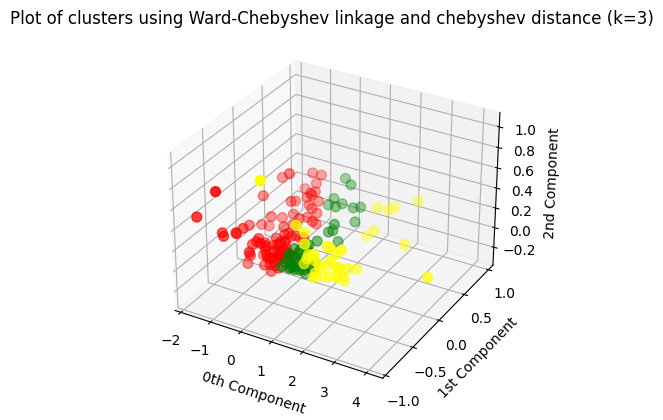

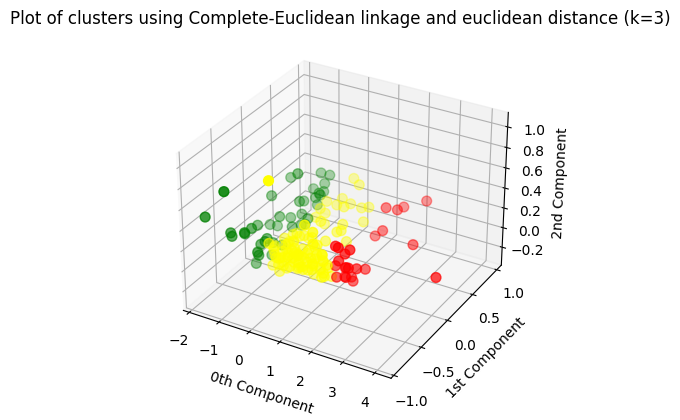

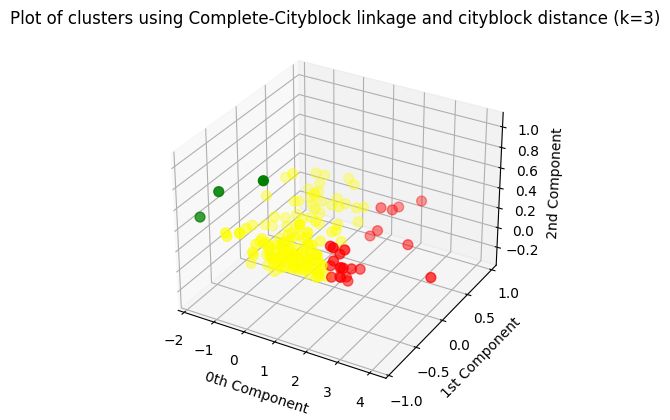

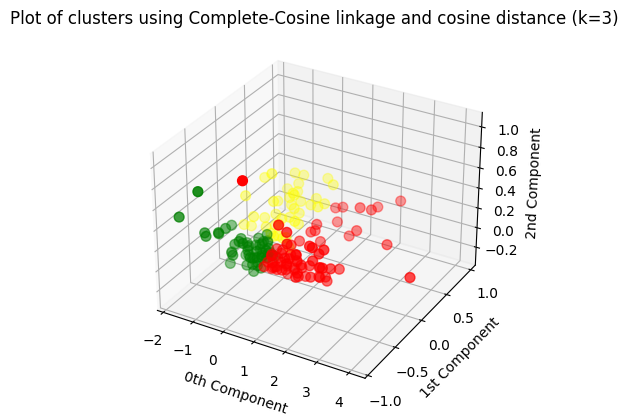

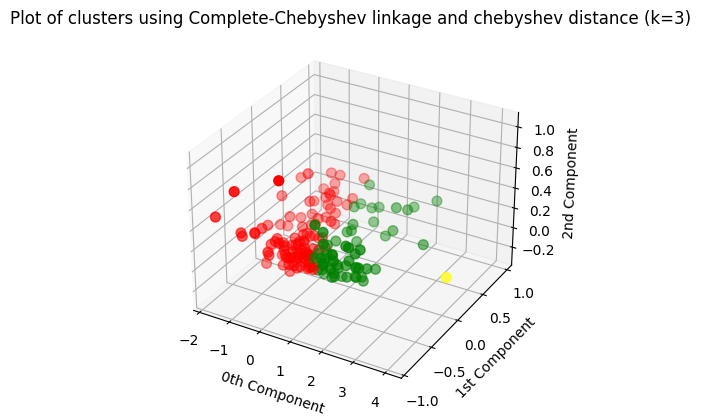

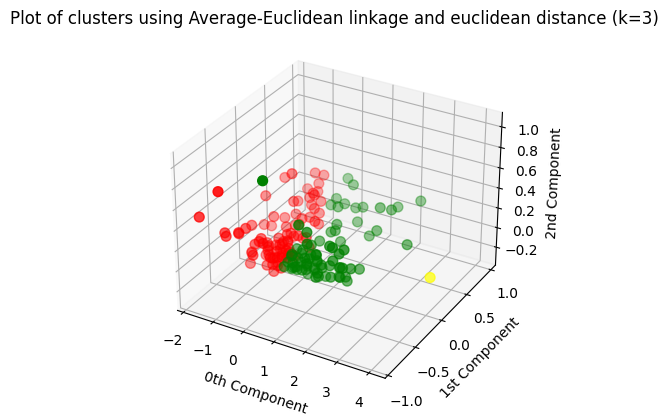

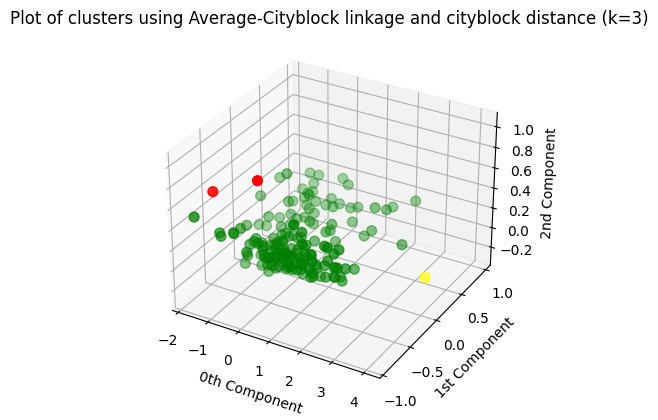

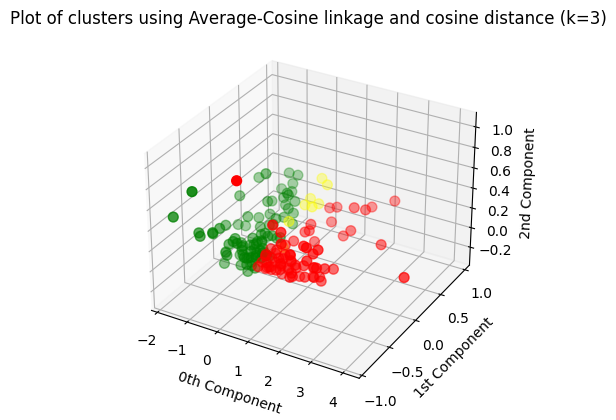

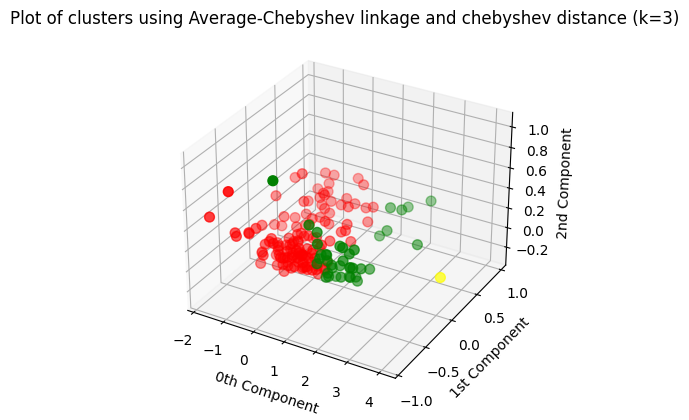

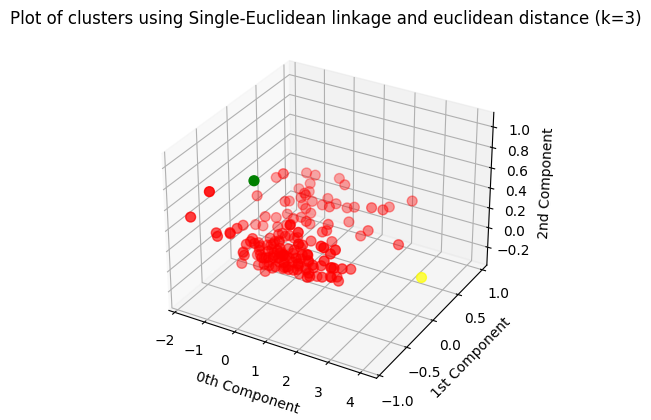

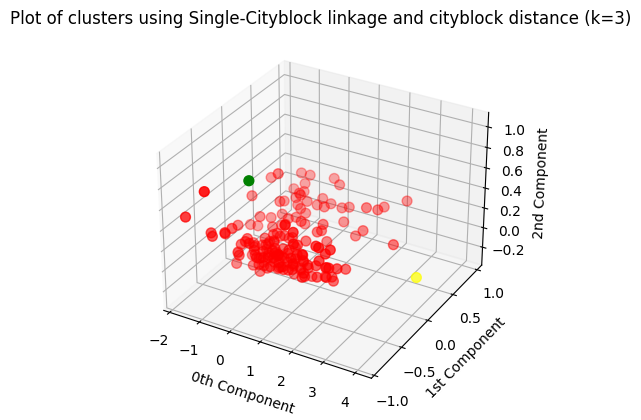

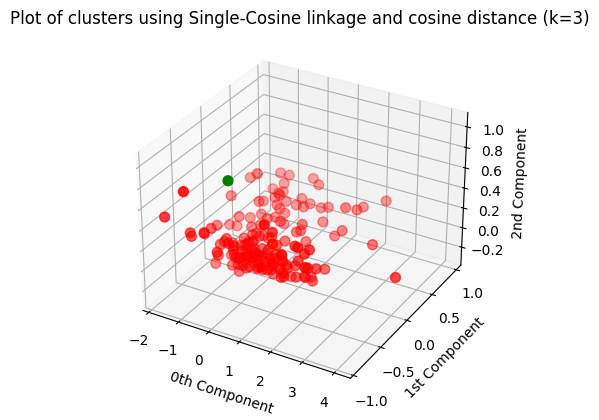

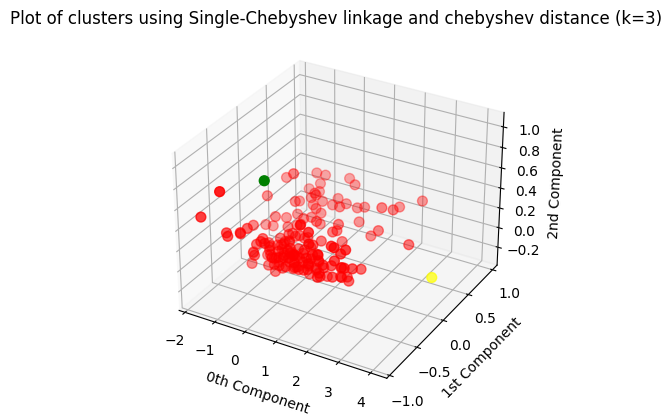

In [ ]:
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import linkage, fcluster

linkage_methods = ['ward', 'complete', 'average', 'single']
distance_metrics = ['euclidean', 'cityblock', 'cosine', 'chebyshev']

# Function to apply Hierarchical Clustering with different combinations of linkage and distance metrics
def apply_hierarchical_model(linkage_method, distance_metric, model_name, m2_pca):
    distance_matrix = pdist(m2_pca, metric=distance_metric)

    Z = linkage(distance_matrix, method=linkage_method)

    labels = fcluster(Z, t=3, criterion='maxclust')

    colors = np.array(['red', 'green', 'yellow'])

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    ax.scatter(m2_pca[:, 0], m2_pca[:, 1], m2_pca[:, 2], c=colors[labels - 1], s=50)

    plt.title(f'Plot of clusters using {model_name} linkage and {distance_metric} distance (k=3)')
    ax.set_xlabel('0th Component')
    ax.set_ylabel('1st Component')
    ax.set_zlabel('2nd Component')
    plt.show()

for linkage_method in linkage_methods:
    for distance_metric in distance_metrics:
        model_name = f'{linkage_method.capitalize()}-{distance_metric.capitalize()}'
        apply_hierarchical_model(linkage_method, distance_metric, model_name, m2_pca)

**Complete-Cosine linkage** formed the most distinct clusters in 3D space, with minimal overlap between the groups, confirming good separation. Ward-Euclidean showed slightly more overlap, which might indicate that data points are closer in terms of Euclidean distance. In contrast, Average-Cosine and Average-Chebyshev formed one underpopulated cluster, indicating suboptimal clustering performance.

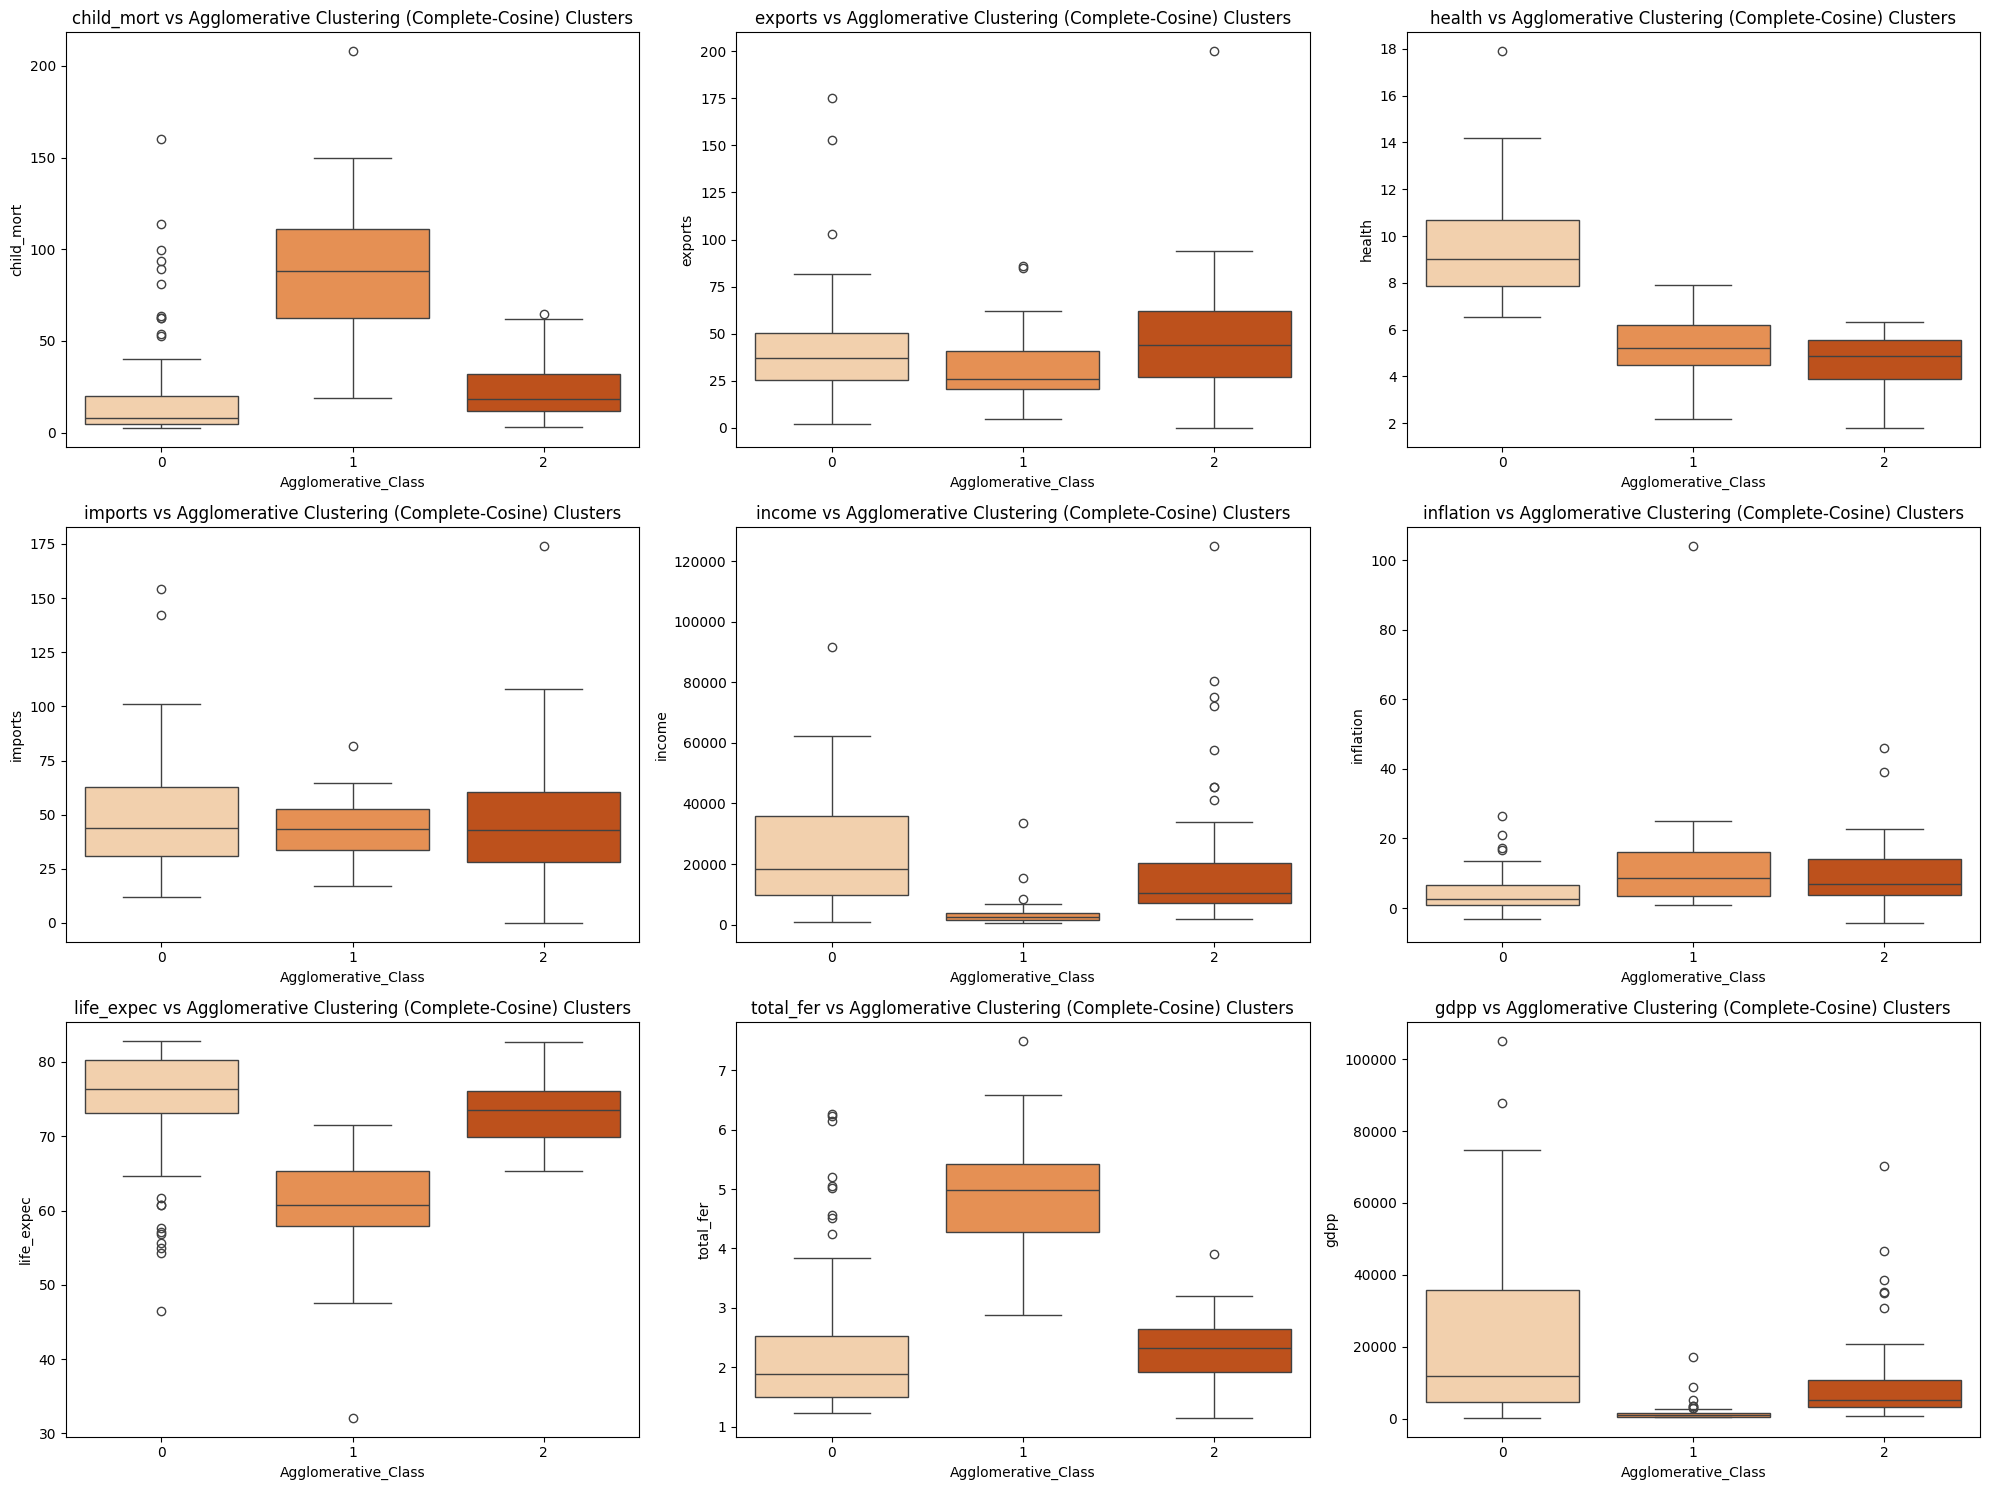

In [ ]:
from sklearn.metrics import pairwise_distances

cosine_dist_matrix = pairwise_distances(m2, metric='cosine')

agglo_model = AgglomerativeClustering(n_clusters=3, linkage='complete', metric='precomputed')
agglo_labels = agglo_model.fit_predict(cosine_dist_matrix)

data['Agglomerative_Class'] = agglo_labels

def plot_boxplots(data, class_column, model_name):
    fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(20, 15))
    axes = axes.flatten()

    for i, attribute in enumerate(attributes):
        sns.boxplot(x=class_column, y=attribute, data=data, palette='Oranges', ax=axes[i])
        axes[i].set_title(f'{attribute} vs {model_name} Clusters')

    plt.tight_layout()
    plt.show()

plot_boxplots(data, 'Agglomerative_Class', 'Agglomerative Clustering (Complete-Cosine)')


In [ ]:
cosine_dist_matrix = pairwise_distances(m2, metric='cosine')

agglo_model = AgglomerativeClustering(n_clusters=3, linkage='complete', metric='precomputed')
agglo_labels = agglo_model.fit_predict(cosine_dist_matrix)

pca_df2['Agglomerative_Class'] = agglo_labels
pca_df2['Country'] = data['country']

def plot_choropleth_for_clusters(pca_df2, class_column, model_name):
    pca_df2[class_column] = pca_df2[class_column].map({
        0: 'No Help Needed',
        1: 'Help Needed',
        2: 'Might Need Help'
    })

    fig = px.choropleth(pca_df2[['Country', class_column]],
                        locationmode='country names',
                        locations='Country',
                        title=f'Needed Help Per Country (World) - {model_name}',
                        color=pca_df2[class_column],
                        color_discrete_map={
                            'Help Needed': 'Red',
                            'Might Need Help': 'Yellow',
                            'No Help Needed': 'Green'
                        })
    fig.update_geos(fitbounds="locations", visible=True)
    fig.update_layout(legend_title_text='Labels', legend_title_side='top', title_pad_l=260, title_y=0.86)
    fig.show()

plot_choropleth_for_clusters(pca_df2, 'Agglomerative_Class', 'Agglomerative Clustering (Complete-Cosine)')


## DBSCAN


Processing min_samples_value = 6


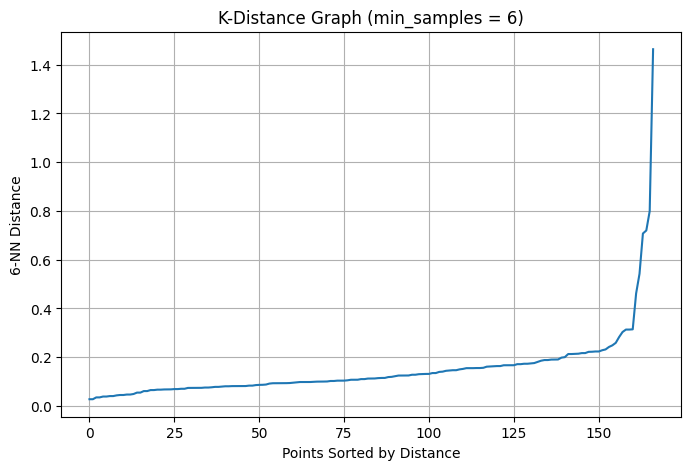

Enter the eps_value based on the K-distance graph for min_samples_value = 6: 0.2
Number of Clusters: 3
Number of Outliers (Noise Points): 82


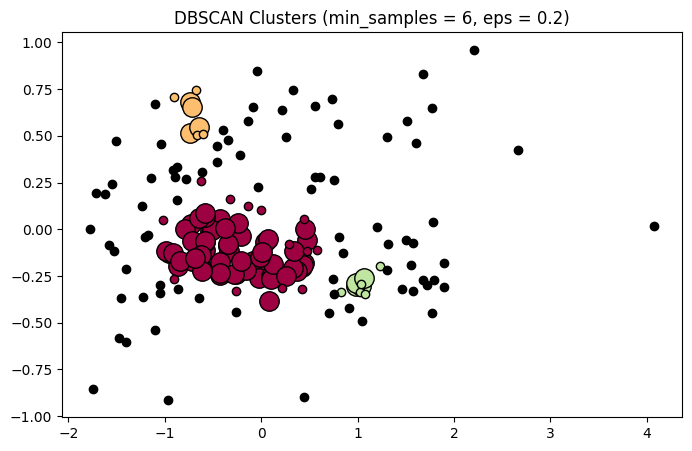

Silhouette Score for min_samples=6, eps=0.2: -0.07242384339406846
Davies-Bouldin Index for min_samples=6, eps=0.2: 2.509239783918143
Calinski-Harabasz Index for min_samples=6, eps=0.2: 8.176597220820547

Processing min_samples_value = 8


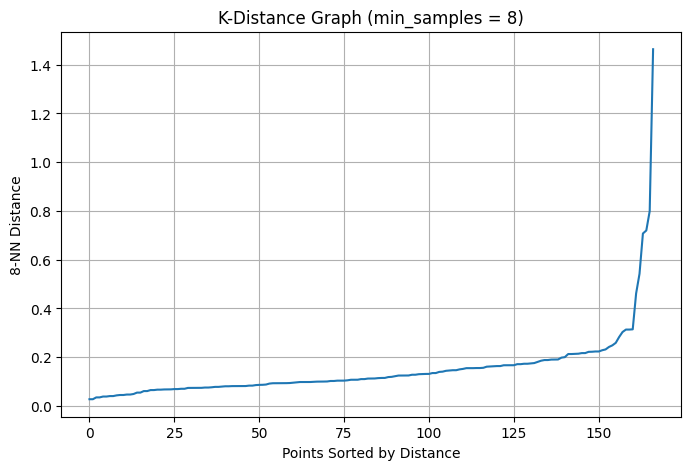

Enter the eps_value based on the K-distance graph for min_samples_value = 8: 0.2
Number of Clusters: 3
Number of Outliers (Noise Points): 94


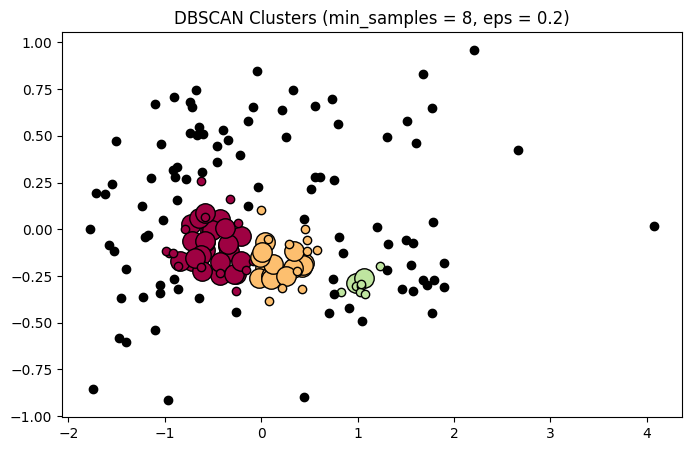

Silhouette Score for min_samples=8, eps=0.2: -0.046432582992759014
Davies-Bouldin Index for min_samples=8, eps=0.2: 2.733148842692974
Calinski-Harabasz Index for min_samples=8, eps=0.2: 8.389896965835373

Processing min_samples_value = 10


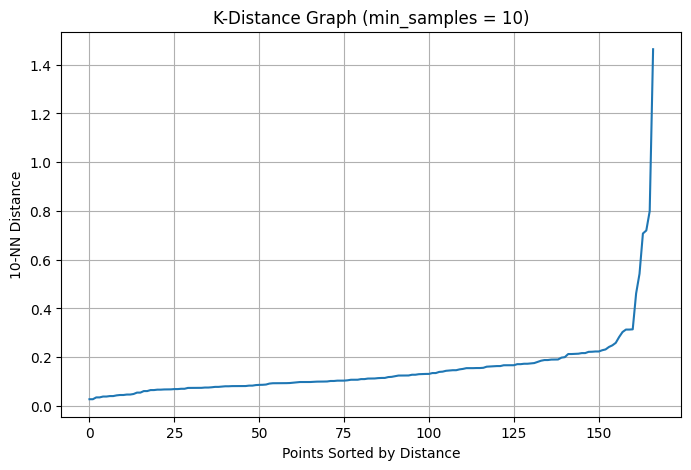

Enter the eps_value based on the K-distance graph for min_samples_value = 10: 0.2
Number of Clusters: 2
Number of Outliers (Noise Points): 108


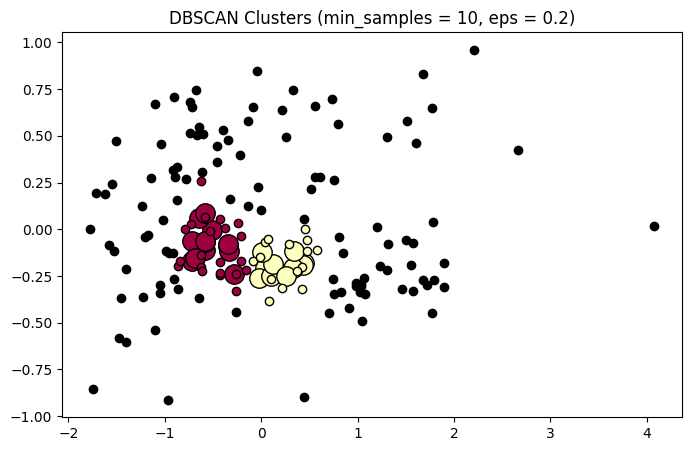

Silhouette Score for min_samples=10, eps=0.2: -0.06373995642436545
Davies-Bouldin Index for min_samples=10, eps=0.2: 3.5020445160489886
Calinski-Harabasz Index for min_samples=10, eps=0.2: 6.3070014990933725

Processing min_samples_value = 12


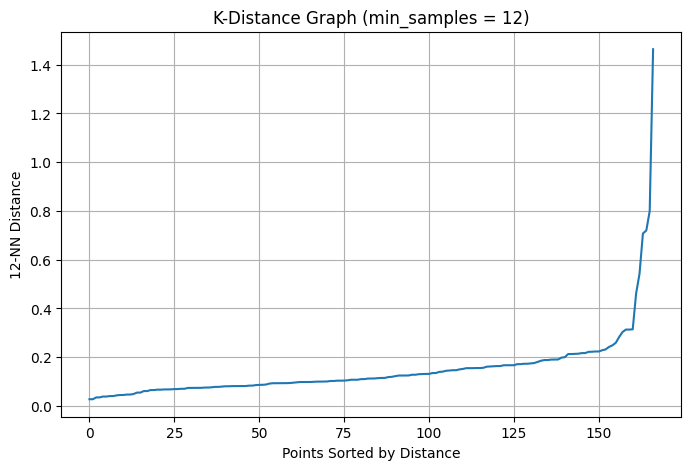

Enter the eps_value based on the K-distance graph for min_samples_value = 12: 0.2
Number of Clusters: 2
Number of Outliers (Noise Points): 124


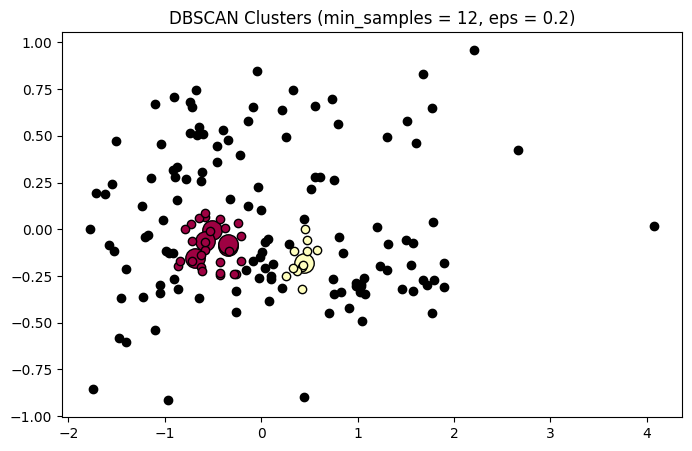

Silhouette Score for min_samples=12, eps=0.2: -0.1635334904605699
Davies-Bouldin Index for min_samples=12, eps=0.2: 2.6058577032655825
Calinski-Harabasz Index for min_samples=12, eps=0.2: 5.830491070169575


In [ ]:
# List of min_samples values to iterate through
min_samples_list = [6, 8, 10, 12]

# Loop over each min_samples value
for min_samples_value in min_samples_list:
    print(f"\nProcessing min_samples_value = {min_samples_value}")

    # Step 1: Compute the k-distance graph
    knn = NearestNeighbors(n_neighbors=min_samples_value)
    model = knn.fit(m2)
    distances, indices = knn.kneighbors(m2)
    distances = np.sort(distances[:, 1], axis=0)

    # Plot the k-distance graph
    plt.figure(figsize=(8, 5))
    plt.plot(distances)
    plt.xlabel('Points Sorted by Distance')
    plt.ylabel(f'{min_samples_value}-NN Distance')
    plt.title(f'K-Distance Graph (min_samples = {min_samples_value})')
    plt.grid(True)
    plt.show()

    # Step 2: Select eps_value based on the elbow point
    eps_value = float(input(f"Enter the eps_value based on the K-distance graph for min_samples_value = {min_samples_value}: "))

    # Step 3: Apply DBSCAN
    db = DBSCAN(eps=eps_value, min_samples=min_samples_value).fit(m2)
    labels = db.labels_
    core_sample_indices = db.core_sample_indices_

    # Step 4: Count clusters and outliers
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise_ = list(labels).count(-1)

    print(f'Number of Clusters: {n_clusters_}')
    print(f'Number of Outliers (Noise Points): {n_noise_}')

    # Step 5: Plot the DBSCAN clusters
    unique_labels = set(labels)
    colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]

    plt.figure(figsize=(8, 5))
    for k, col in zip(unique_labels, colors):
        if k == -1:
            col = [0, 0, 0, 1]

        class_member_mask = (labels == k)

        # Core points
        xy_core = m2[class_member_mask & np.isin(np.arange(len(m2)), core_sample_indices)]
        plt.plot(xy_core[:, 0], xy_core[:, 1], 'o', markerfacecolor=tuple(col),
                 markeredgecolor='k', markersize=14)

        # Non-core points
        xy_non_core = m2[class_member_mask & ~np.isin(np.arange(len(m2)), core_sample_indices)]
        plt.plot(xy_non_core[:, 0], xy_non_core[:, 1], 'o', markerfacecolor=tuple(col),
                 markeredgecolor='k', markersize=6)

    plt.title(f"DBSCAN Clusters (min_samples = {min_samples_value}, eps = {eps_value})")
    plt.show()

    # Step 6: Calculate clustering metrics if there are at least 2 clusters
    if n_clusters_ > 1:
        silhouette_avg = silhouette_score(m2, labels)
        davies_bouldin = davies_bouldin_score(m2, labels)
        calinski_harabasz = calinski_harabasz_score(m2, labels)

        print(f"Silhouette Score for min_samples={min_samples_value}, eps={eps_value}: {silhouette_avg}")
        print(f"Davies-Bouldin Index for min_samples={min_samples_value}, eps={eps_value}: {davies_bouldin}")
        print(f"Calinski-Harabasz Index for min_samples={min_samples_value}, eps={eps_value}: {calinski_harabasz}")
    else:
        print(f"Not enough clusters to calculate metrics for min_samples={min_samples_value}, eps={eps_value}")


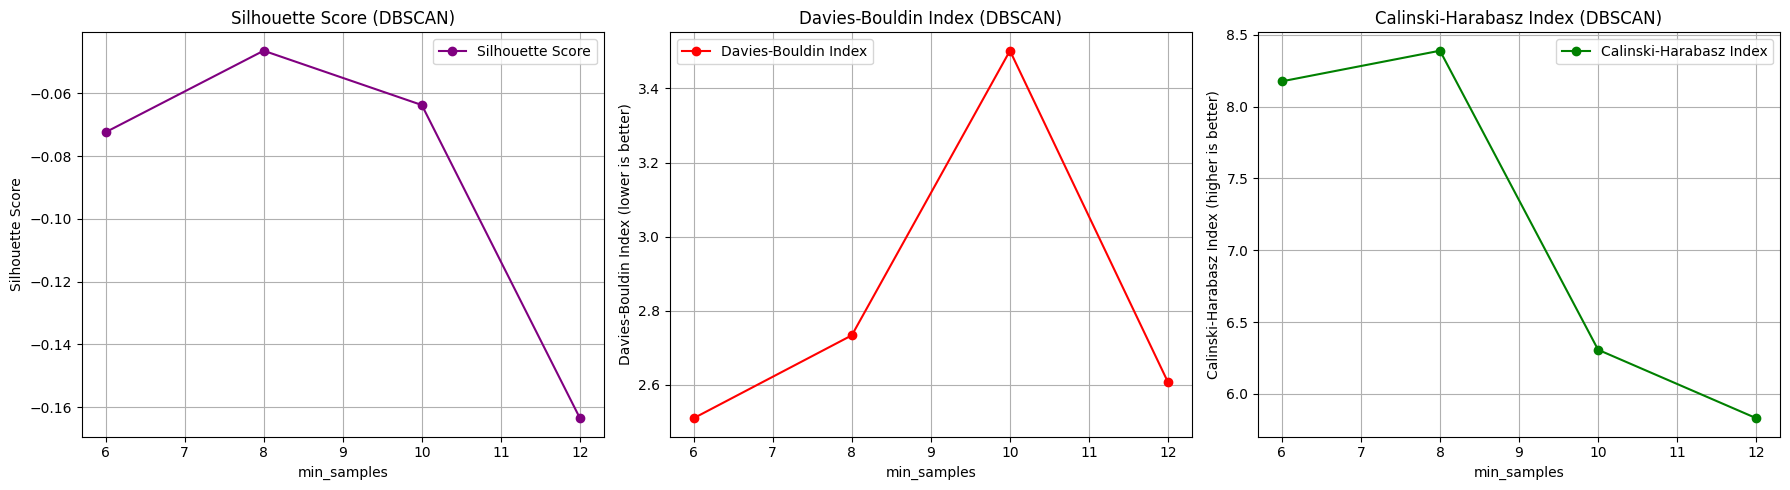

In [ ]:
min_samples_values = [6, 8, 10, 12]
silhouette_scores = [-0.07242384339406846, -0.046432582992759014, -0.06373995642436545, -0.1635334904605699]
davies_bouldin_scores = [2.509239783918143, 2.733148842692974, 3.5020445160489886, 2.6058577032655825]
calinski_harabasz_scores = [8.176597220820547, 8.389896965835373, 6.3070014990933725, 5.830491070169575]

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(18, 5))

ax[0].plot(min_samples_values, silhouette_scores, marker='o', color='purple', label='Silhouette Score')
ax[0].set_title('Silhouette Score (DBSCAN)')
ax[0].set_xlabel("min_samples")
ax[0].set_ylabel("Silhouette Score")
ax[0].grid(True)
ax[0].legend()

ax[1].plot(min_samples_values, davies_bouldin_scores, marker='o', color='r', label='Davies-Bouldin Index')
ax[1].set_title('Davies-Bouldin Index (DBSCAN)')
ax[1].set_xlabel("min_samples")
ax[1].set_ylabel("Davies-Bouldin Index (lower is better)")
ax[1].grid(True)
ax[1].legend()

ax[2].plot(min_samples_values, calinski_harabasz_scores, marker='o', color='g', label='Calinski-Harabasz Index')
ax[2].set_title('Calinski-Harabasz Index (DBSCAN)')
ax[2].set_xlabel("min_samples")
ax[2].set_ylabel("Calinski-Harabasz Index (higher is better)")
ax[2].grid(True)
ax[2].legend()

plt.tight_layout()
plt.show()

From the evaluation, the combination of **min_samples = 8 and eps = 0.2** performed the best:

*   It had the highest Silhouette Score (-0.0464), indicating better separation than other settings.
*   The Davies-Bouldin Index (2.7331) was close to the best score, showing good compactness and separation.
*   The Calinski-Harabasz Index (8.3899) was the highest, reflecting superior between-cluster dispersion.

Overall, **min_samples = 8 and eps = 0.2** provided the best balance of well-separated clusters and compactness, making it the most suitable parameter setting for clustering in this dataset.




In [ ]:
# Apply DBSCAN with eps=0.2 and min_samples=8
db = DBSCAN(eps=0.2, min_samples=8).fit(m2)
labels = db.labels_

n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print(f'Number of Clusters: {n_clusters_}')
print(f'Number of Noise Points: {n_noise_}')

if n_clusters_ > 1:
    silhouette_avg = silhouette_score(m2, labels)
    davies_bouldin = davies_bouldin_score(m2, labels)
    calinski_harabasz = calinski_harabasz_score(m2, labels)

    print(f"Silhouette Score: {silhouette_avg}")
    print(f"Davies-Bouldin Index: {davies_bouldin}")
    print(f"Calinski-Harabasz Index: {calinski_harabasz}")
else:
    print("Not enough clusters to calculate metrics.")


Number of Clusters: 3
Number of Noise Points: 94
Silhouette Score: -0.046432582992759014
Davies-Bouldin Index: 2.733148842692974
Calinski-Harabasz Index: 8.389896965835373


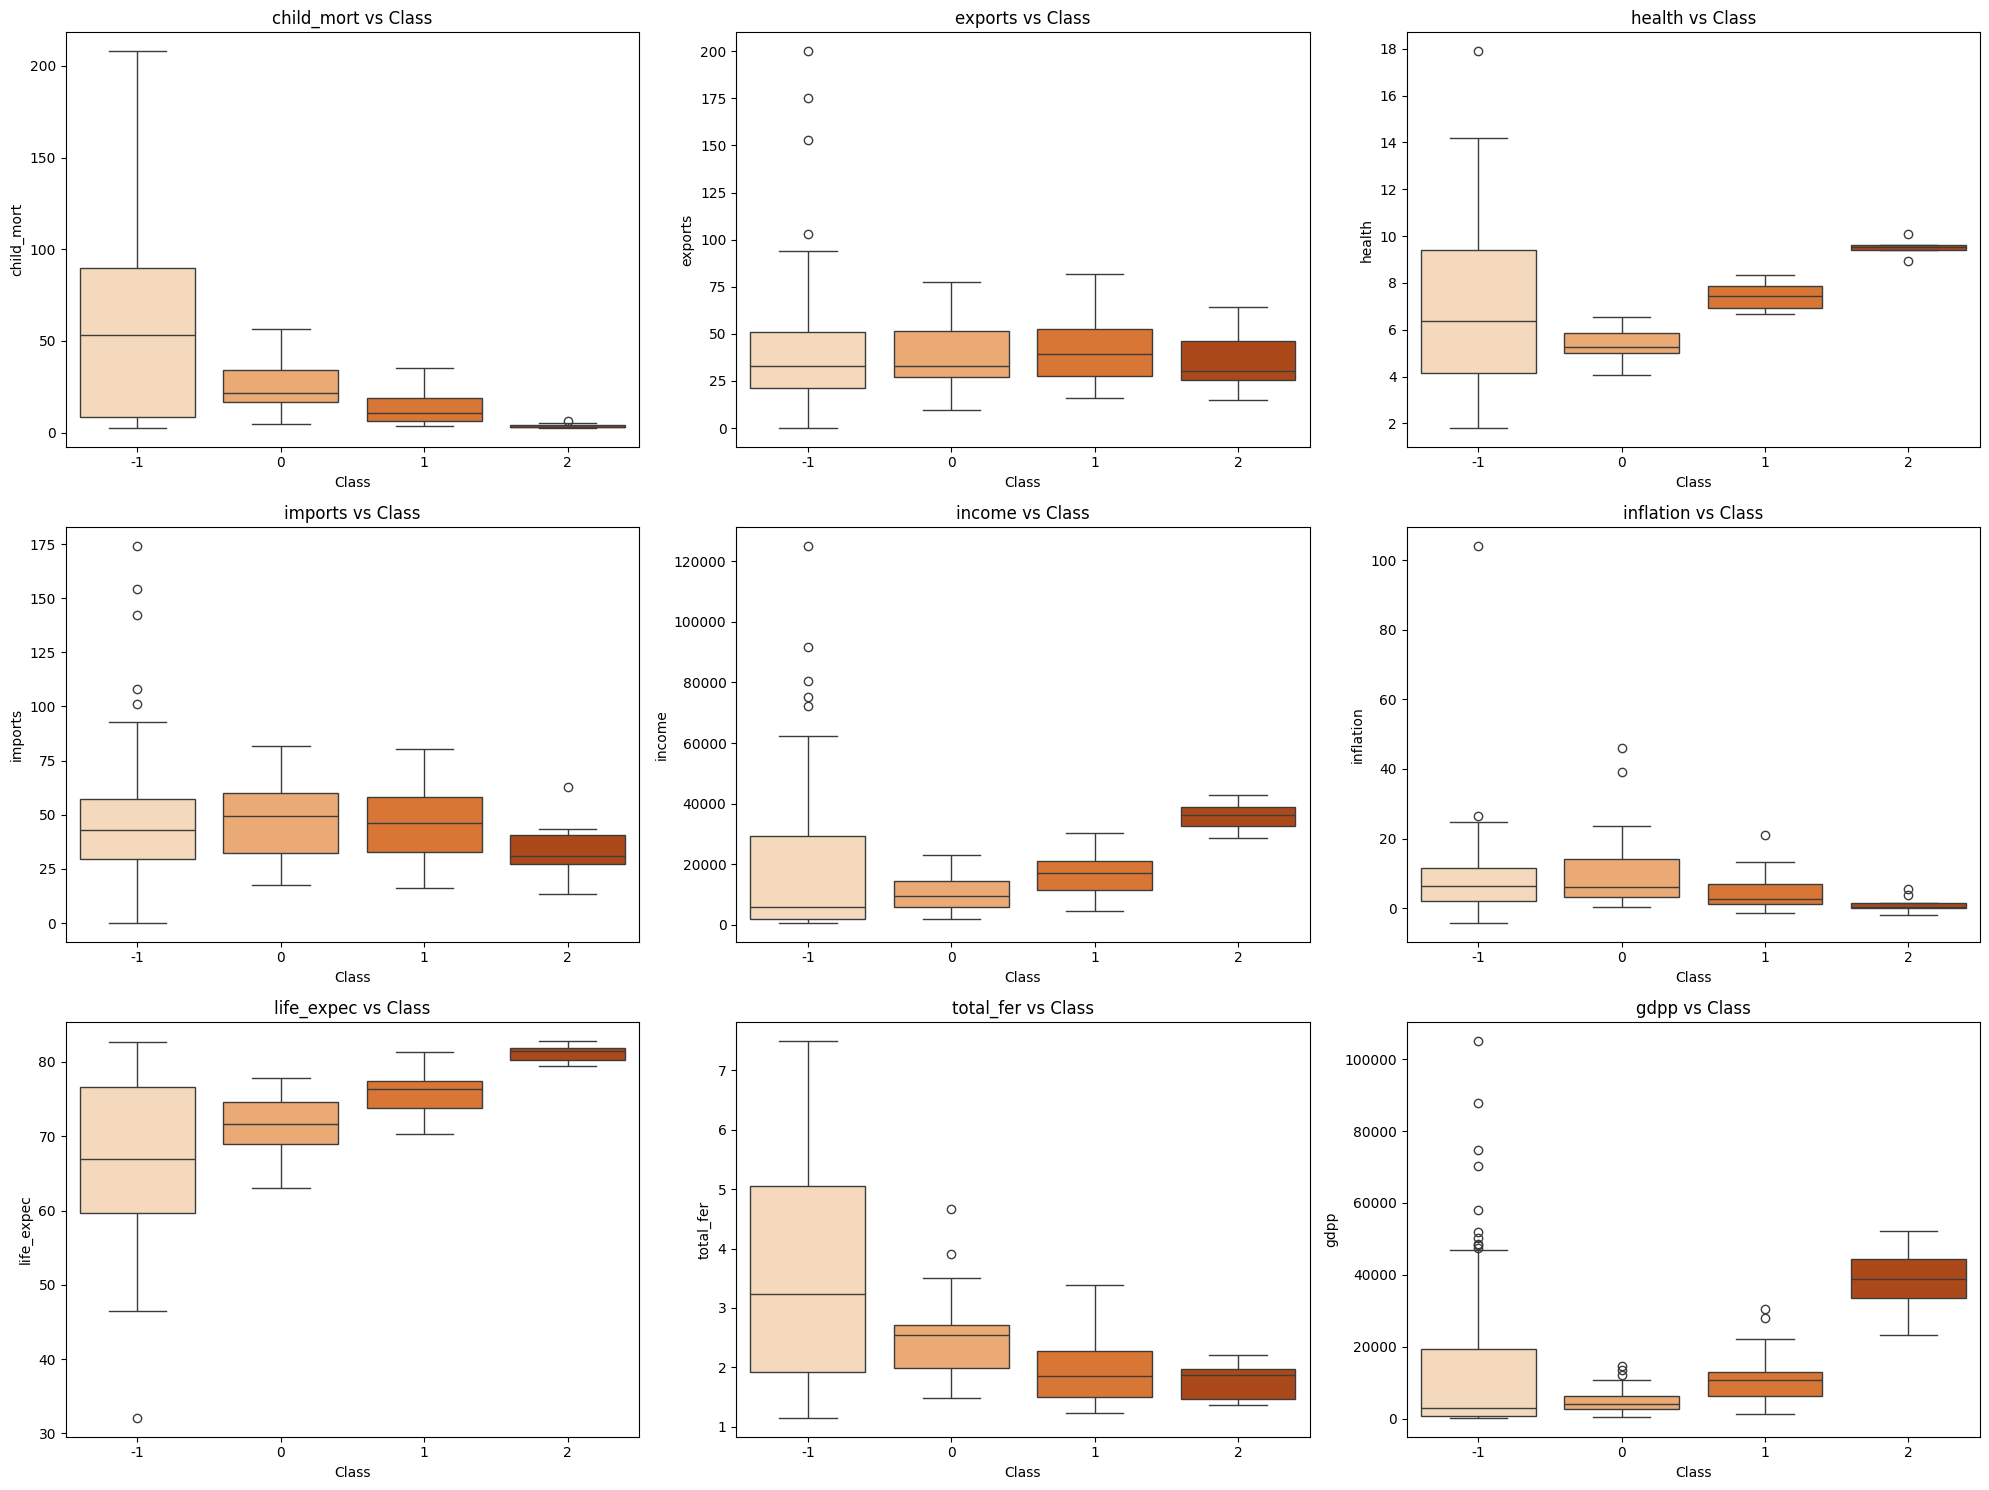

In [ ]:
data['Class'] = labels

attributes = ['child_mort', 'exports', 'health', 'imports', 'income', 'inflation', 'life_expec', 'total_fer', 'gdpp']

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(20, 15))

axes = axes.flatten()

for i, attribute in enumerate(attributes):
    sns.boxplot(x='Class', y=attribute, data=data, palette='Oranges', ax=axes[i])
    axes[i].set_title(f'{attribute} vs Class')

plt.tight_layout()
plt.show()

In [ ]:
pca_df2['Class'] = labels
pca_df2['Country'] = data['country']

pca_df2['Class'].loc[pca_df2['Class'] == -1] = 'Noise / Outliers'
pca_df2['Class'].loc[pca_df2['Class'] == 0] = 'Help Needed'
pca_df2['Class'].loc[pca_df2['Class'] == 1] = 'Might Need Help'
pca_df2['Class'].loc[pca_df2['Class'] == 2] ='No Help Needed'

fig = px.choropleth(pca_df2[['Country','Class']],
                    locationmode = 'country names',
                    locations = 'Country',
                    title = 'Needed Help Per Country (World)',
                    color_discrete_sequence=["orange", "red", "green",'black'],
                    color = pca_df2['Class'],
                    color_discrete_map={'Noise / Outliers' : 'Black',
                                        'Help Needed':'Red',
                                        'Might Need Help':'Yellow',
                                        'No Help Needed':'Green'})
fig.update_geos(fitbounds = "locations", visible = True)
fig.update_layout(legend_title_text = 'Labels',legend_title_side = 'top',title_pad_l = 260,title_y = 0.86)
fig.show(engine = 'kaleido')